In [2]:
import ROOT
from rootpy.tree import Tree, TreeModel, FloatCol, IntCol
from rootpy.io import root_open
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random

from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
#mc = rp.read_root('/fhgfs/users/chasenberg/mc/dimuon_stripping/Bd2JpsiKS_Dimuon_flattened_cut.root',"Bd2JpsiKs",columns=['B0_FitDaughtersConst*'],flatten=True)
#mc.to_csv('Bd2JpsiKS_Dimuon_flattened_B0_FitDaughtersConst.csv')
#data_sideband = rp.read_root('/fhgfs/users/chasenberg/data/2015/sideband/Bd2JpsiKS_data_2015_flattened_cut_uppersideband.root',"Bd2JpsiKs",columns=['B0_FitDaughtersConst*'],flatten=True)
#data_sideband.to_csv('Bd2JpsiKS_data_2015_flattened_sideband_B0_FitDaughtersConst.csv')
#mc.head(n=5)

In [5]:
#directories and files 
data_dir = '/fhgfs/users/chasenberg/data/2015/jpsiks/flattened/'
data_file ='Bd2JpsiKS_data_2015_flattened.root'

mc_dir = '/fhgfs/users/chasenberg/mc/dimuon_stripping/'
mc_file = 'Bd2JpsiKS_Dimuon_flattened.root'

data_dir = os.path.join(data_dir, data_file)
mc_dir = os.path.join(mc_dir, mc_file)

In [6]:
#criteria and information for read in data
branch_names_data = ['B0_M','B0_FitDaughtersConst*','idxPV','B0_FitPVConst_status','B0_FitPVConst_KS0_tau','B0_FitPVConst_KS0_tau*','B0_L0MuonDecision_TOS','B0_Hlt1TrackMuonDecision_TOS','B0_Hlt2DiMuonJPsiDecision_TOS']
cut_string_data = 'B0_FitDaughtersConst_J_psi_1S_PT_flat>=2000&B0_FitDaughtersConst_status==0&B0_FitPVConst_status==0&idxPV==0&B0_FitDaughtersConst_M>5450&((B0_L0Global_TOS==1)|(B0_Hlt1DiMuonHighMassDecision_TOS==1)|B0_Hlt2DiMuonDetachedJPsiDecision_TOS==1)'
tree_data = 'Bd2JpsiKs'

In [7]:
#criteria and information for read in mc
branch_names_mc = ['B0_M','B0_FitDaughtersConst*','idxPV','B0_FitPVConst_status','B0_FitPVConst_KS0_tau*','B0_BKGCAT','B0_L0MuonDecision_TOS','B0_Hlt1TrackMuonDecision_TOS','B0_Hlt2DiMuonJPsiDecision_TOS']
cut_string_mc = 'B0_FitDaughtersConst_J_psi_1S_PT_flat>=2000&B0_FitDaughtersConst_status==0&B0_FitPVConst_status==0&idxPV==0&B0_FitDaughtersConst_M<5350&B0_FitDaughtersConst_M>5220&((B0_BKGCAT==10)|(B0_BKGCAT==50))&((B0_L0Global_TOS==1)|(B0_Hlt1DiMuonHighMassDecision_TOS==1)|B0_Hlt2DiMuonDetachedJPsiDecision_TOS==1)'
tree_mc = 'Bd2JpsiK'

In [8]:
#read root files
bkg_dataframe = rp.read_root(data_dir,key=tree_data,columns=branch_names_data,where=cut_string_data, flatten=True)
bkg_dataframe = bkg_dataframe.replace([np.inf, -np.inf], np.nan)
bkg_dataframe = bkg_dataframe.dropna()
signal_dataframe = rp.read_root(mc_dir,key=tree_mc,columns=branch_names_mc,where=cut_string_mc, flatten=True)
signal_dataframe = signal_dataframe.replace([np.inf, -np.inf], np.nan)
signal_dataframe = signal_dataframe.dropna()

In [38]:
#Generate dimensionless decay-time distribution
bkg_dataframe['B0_FitPVConst_KS0_tau_dimless'] = bkg_dataframe['B0_FitPVConst_KS0_tau']/bkg_dataframe['B0_FitPVConst_KS0_tauErr']
signal_dataframe['B0_FitPVConst_KS0_tau_dimless'] = signal_dataframe['B0_FitPVConst_KS0_tau']/signal_dataframe['B0_FitPVConst_KS0_tauErr']

In [9]:
#data_sideband = pd.read_csv('Bd2JpsiKS_data_2015_flattened_sideband_B0_FitDaughtersConst.csv', index_col = 0)
#mc = pd.read_csv('Bd2JpsiKS_Dimuon_flattened_B0_FitDaughtersConst.csv',index_col = 0)
#data_sideband.head(n=5)

In [10]:
observables = list(bkg_dataframe.columns.values)

observables[0]


'B0_M'

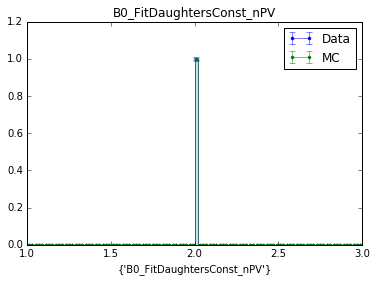

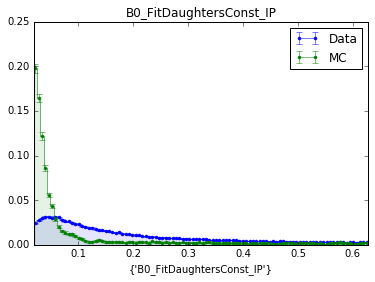

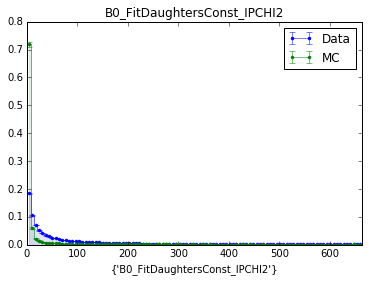

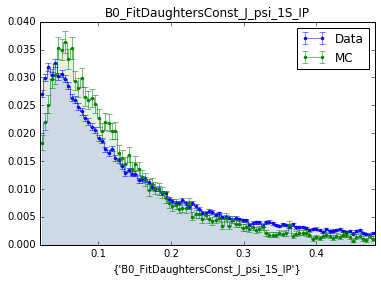

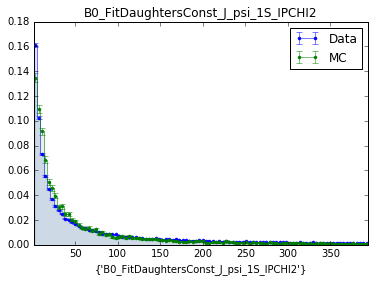

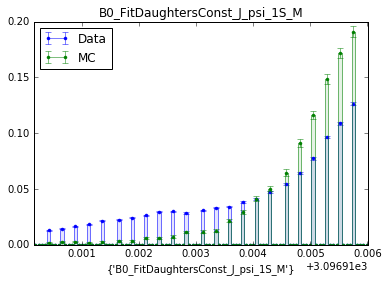

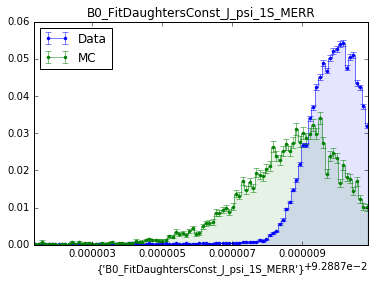

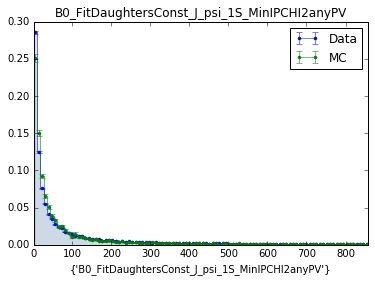

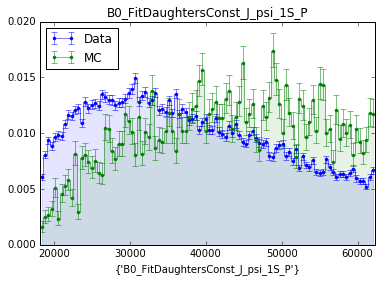

/home/chasenberg/repos/dopy/doplot/statistics.py:8: RuntimeWarning: invalid value encountered in true_divide
  values   = np.array(values, dtype='float') / integral
/home/chasenberg/repos/dopy/doplot/statistics.py:11: RuntimeWarning: divide by zero encountered in true_divide
  errors   = errors / integral
/home/chasenberg/repos/dopy/doplot/statistics.py:11: RuntimeWarning: invalid value encountered in true_divide
  errors   = errors / integral
/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-13.0, right=-13.0
  'left=%s, right=%s') % (left, right))


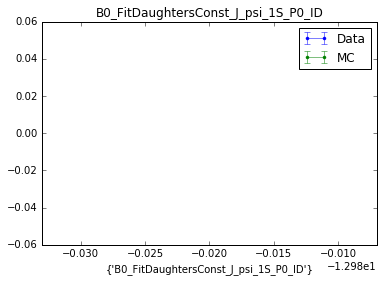

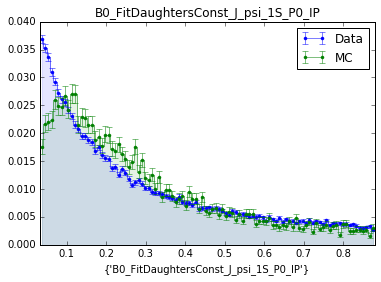

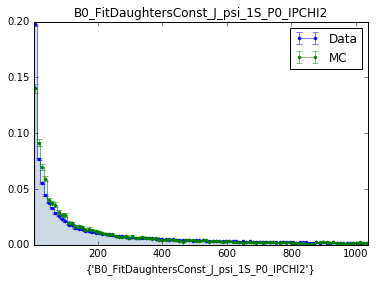

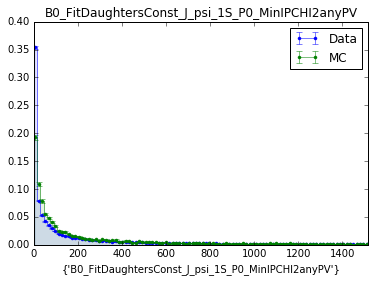

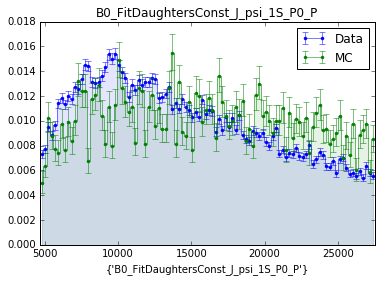

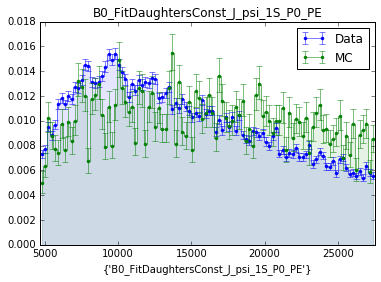

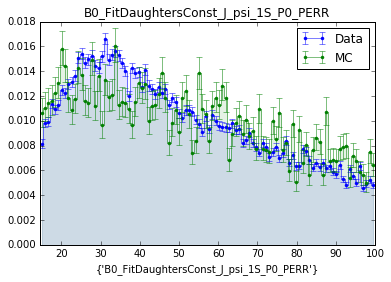

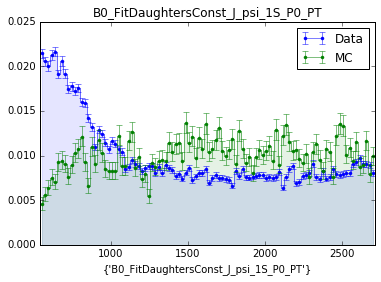

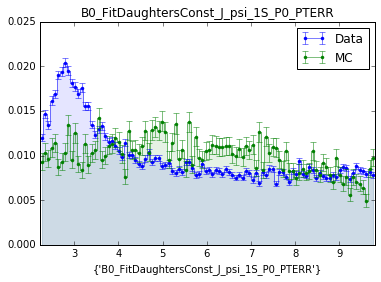

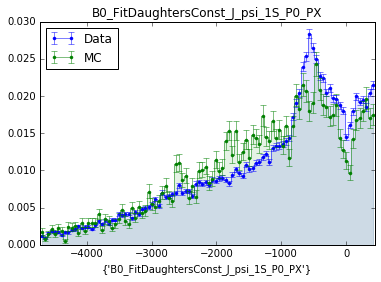

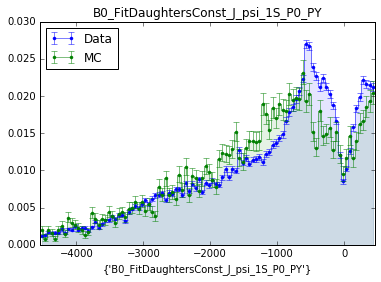

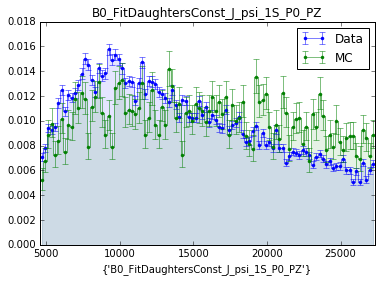

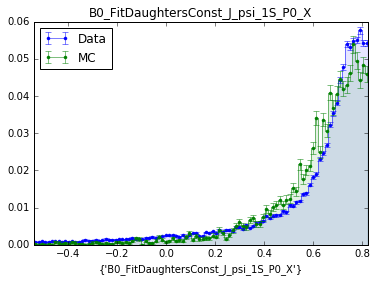

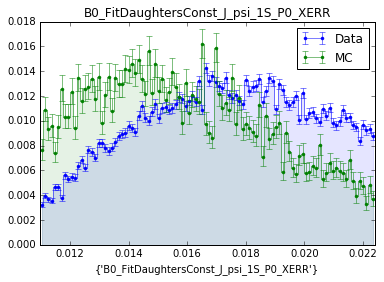

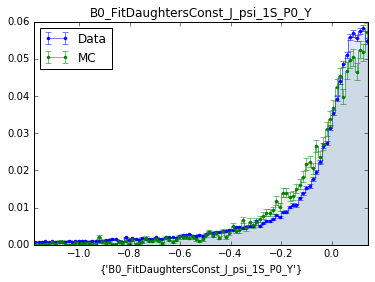

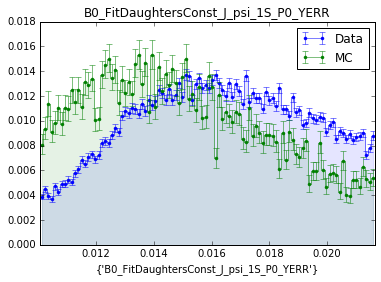

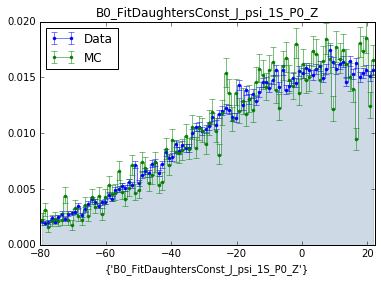

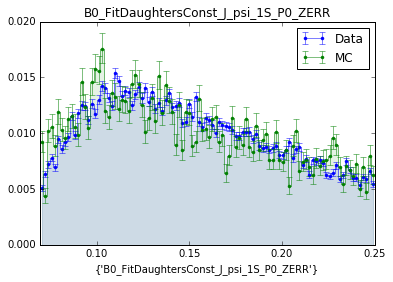

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=13.0, right=13.0
  'left=%s, right=%s') % (left, right))


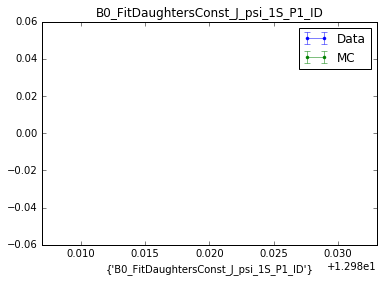

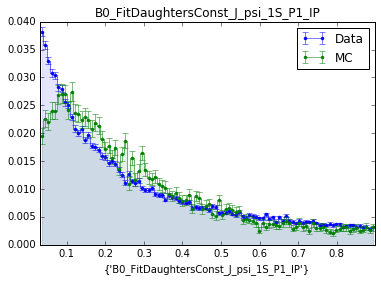

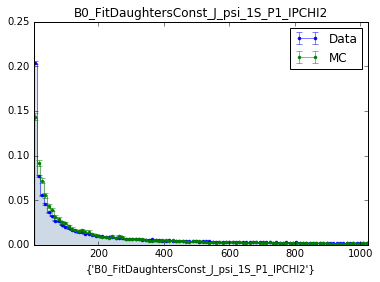

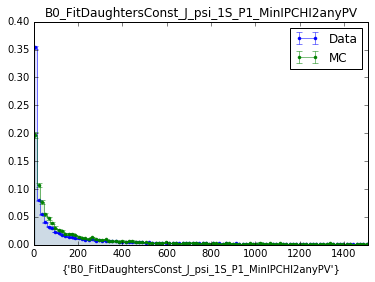

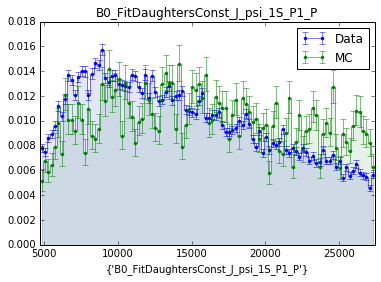

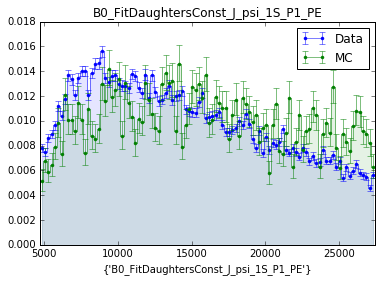

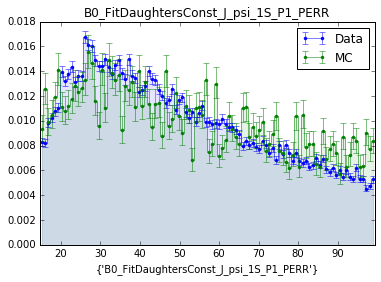

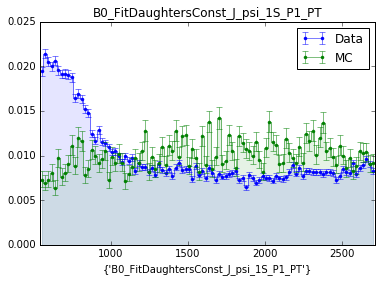

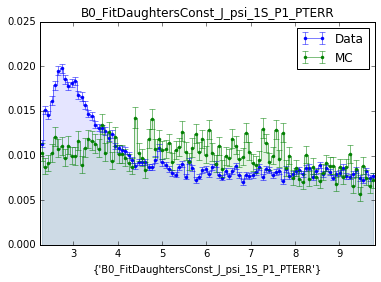

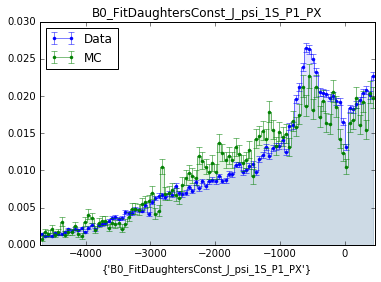

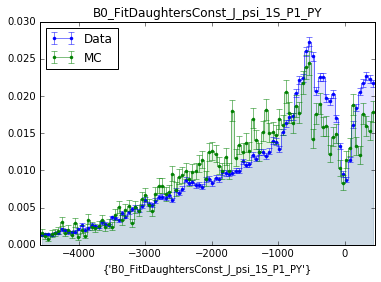

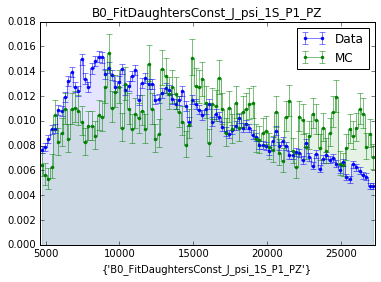

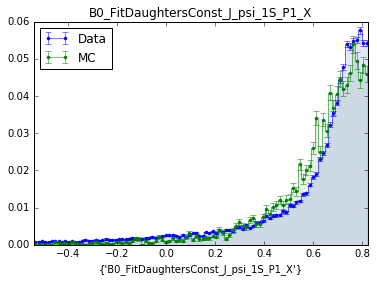

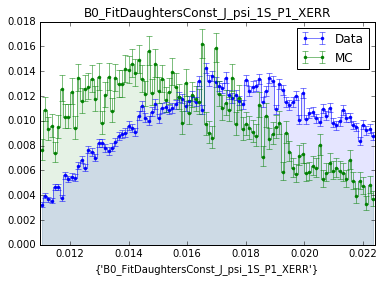

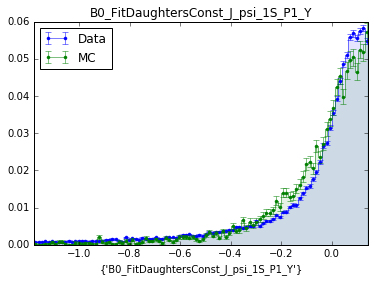

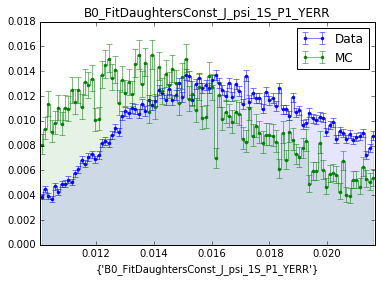

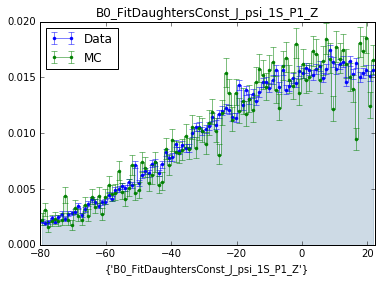

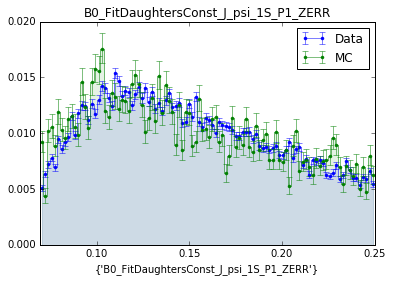

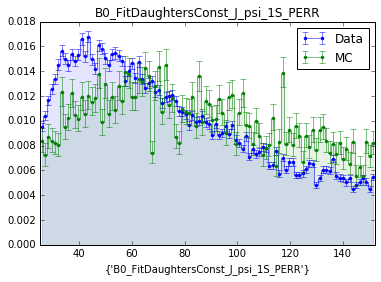

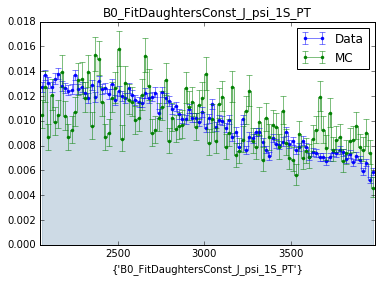

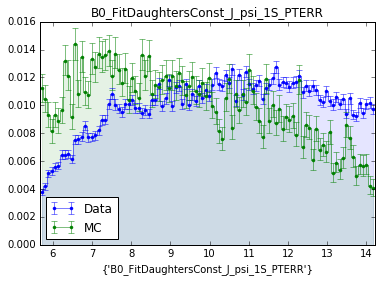

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


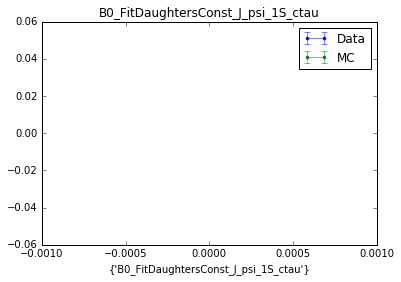

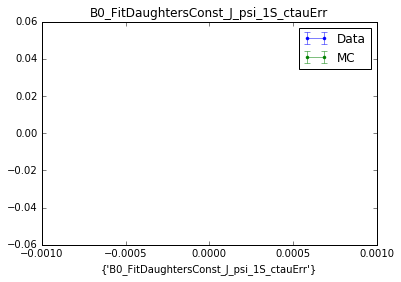

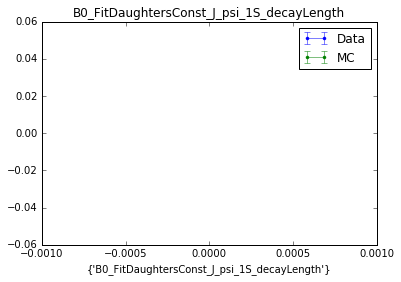

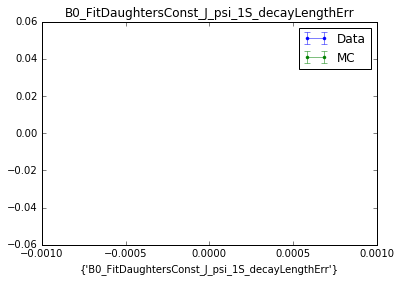

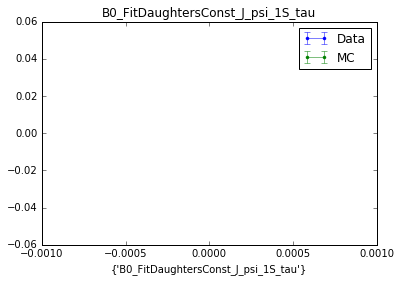

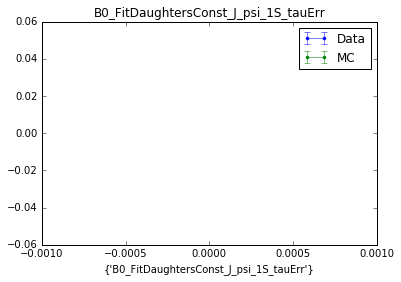

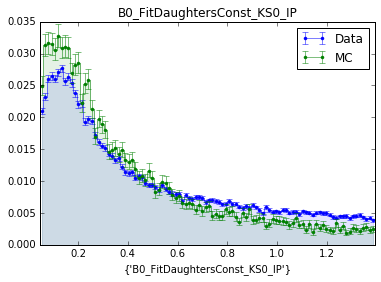

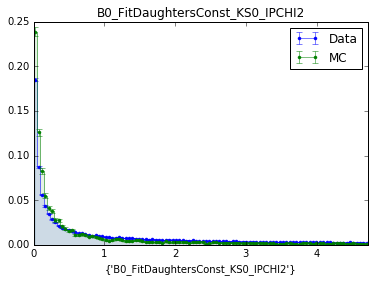

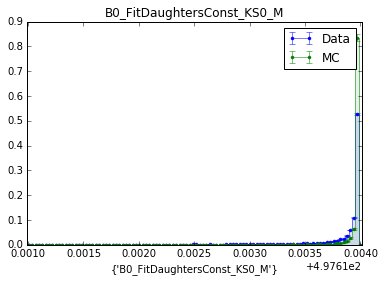

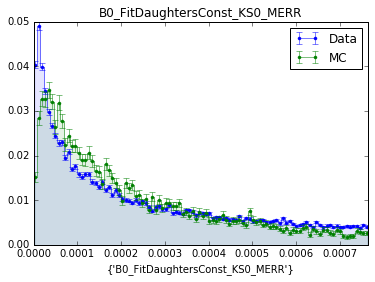

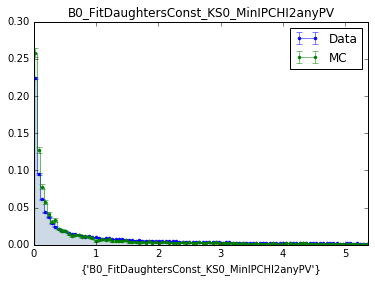

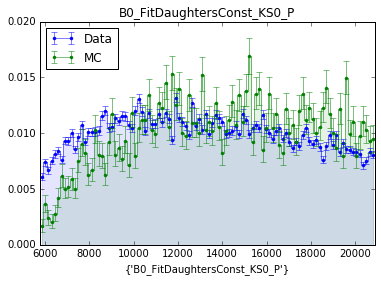

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=211.0, right=211.0
  'left=%s, right=%s') % (left, right))


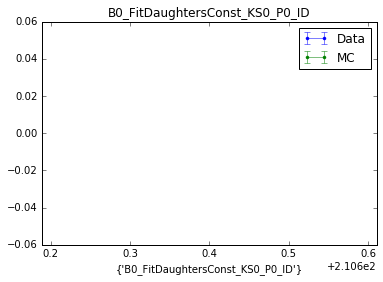

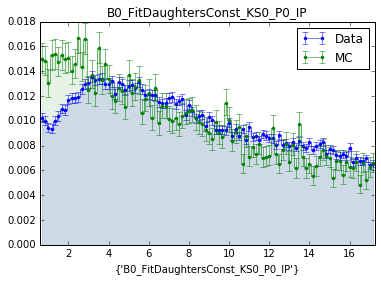

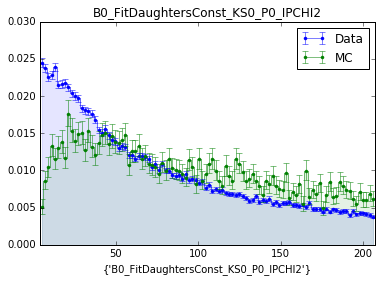

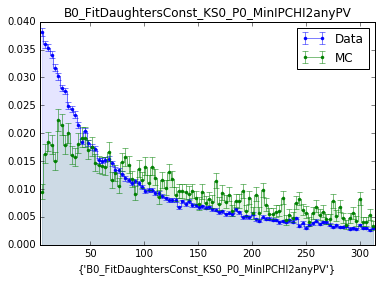

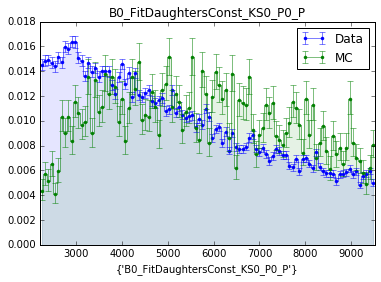

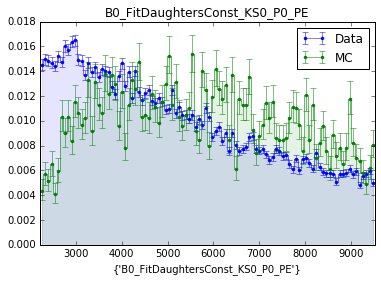

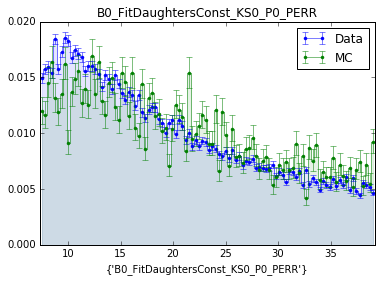

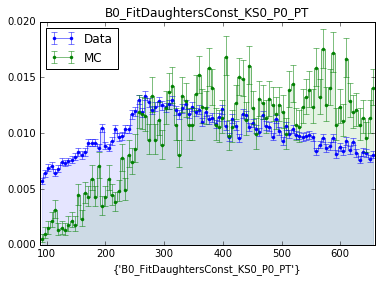

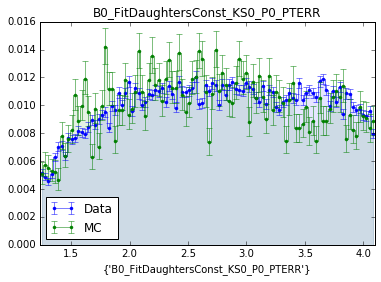

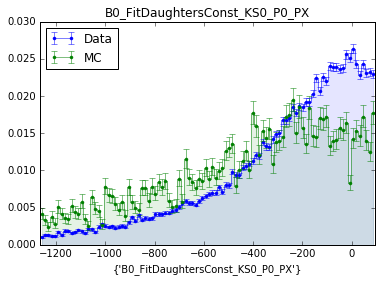

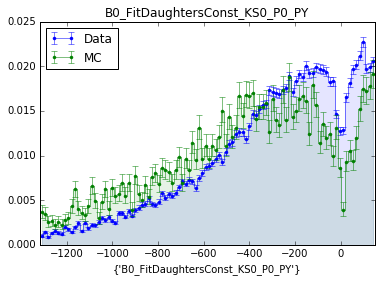

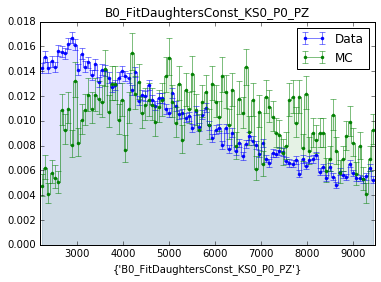

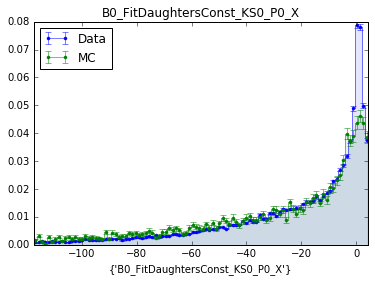

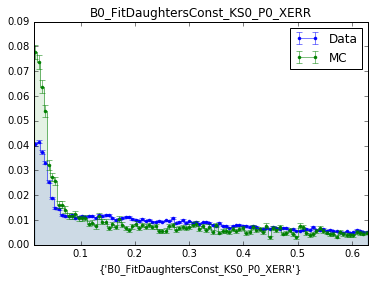

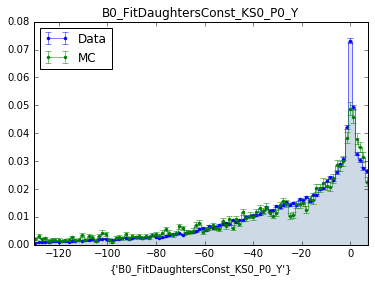

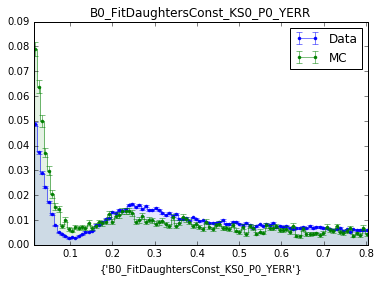

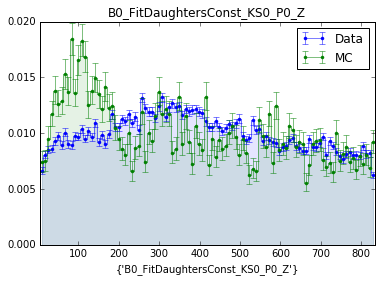

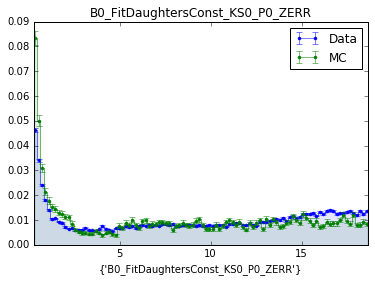

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-211.0, right=-211.0
  'left=%s, right=%s') % (left, right))


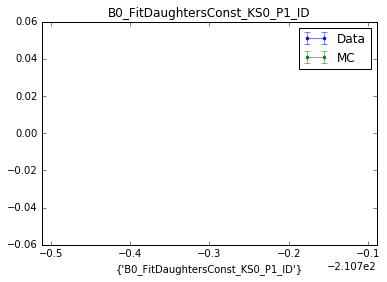

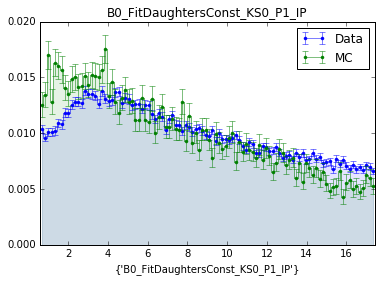

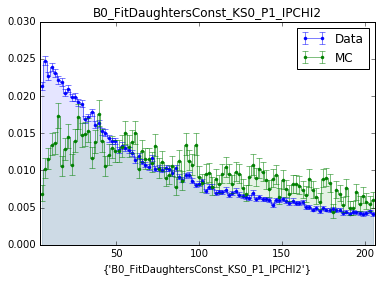

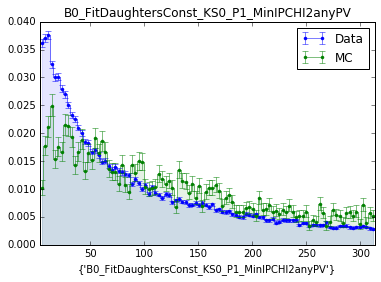

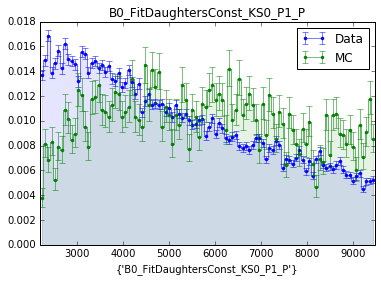

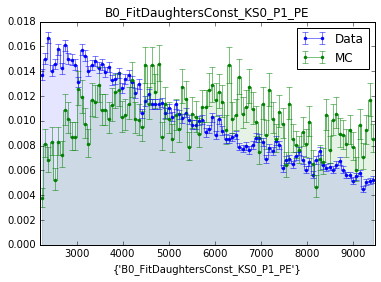

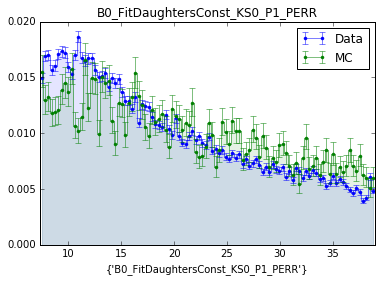

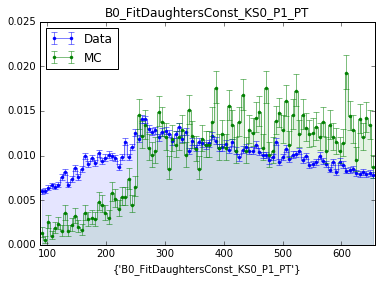

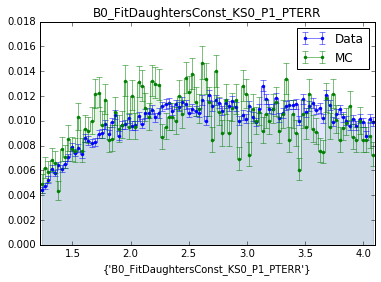

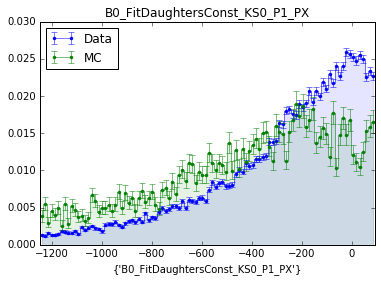

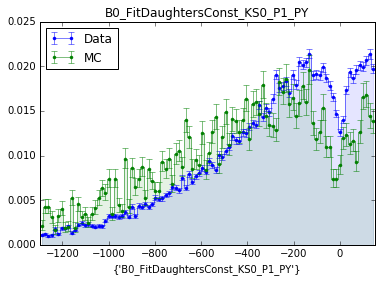

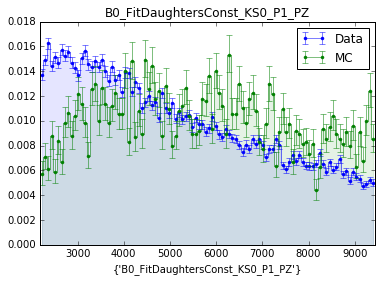

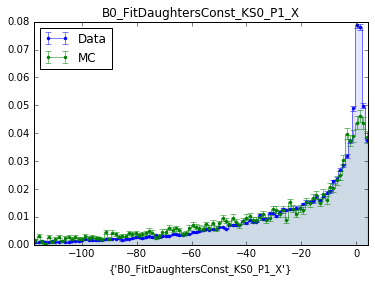

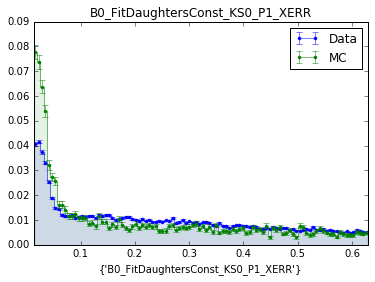

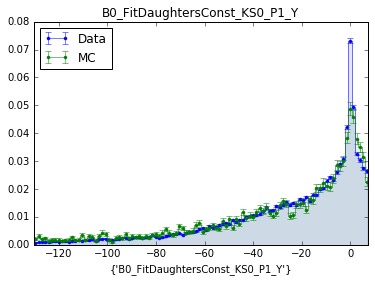

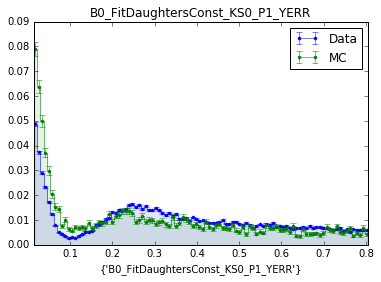

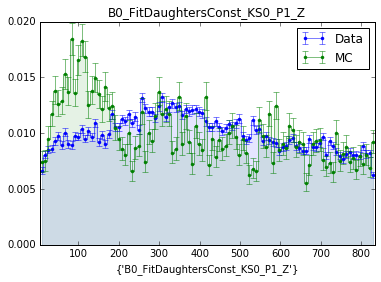

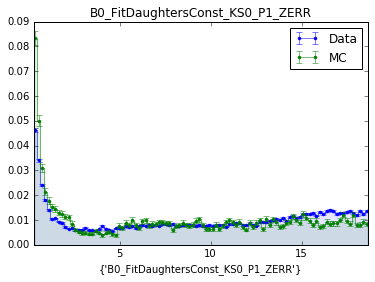

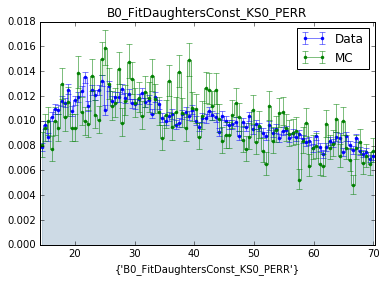

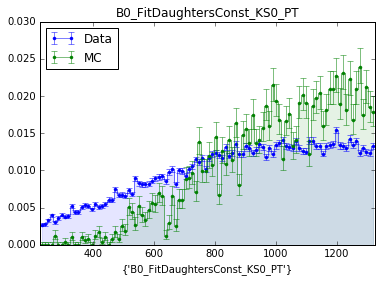

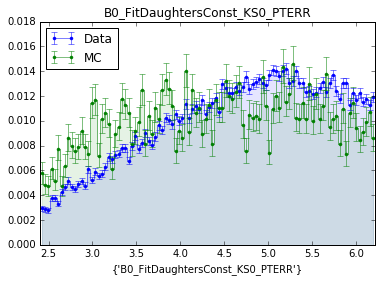

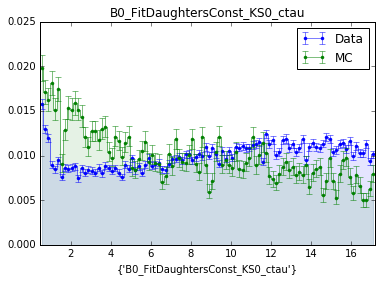

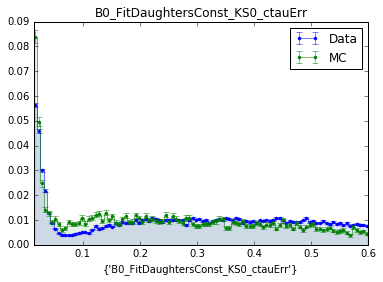

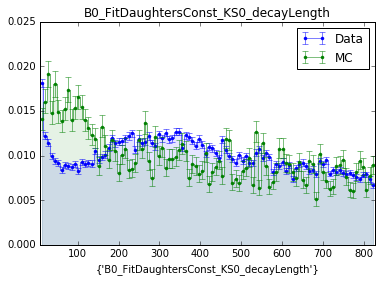

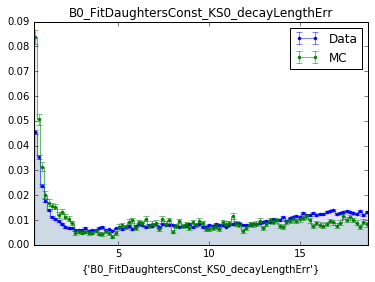

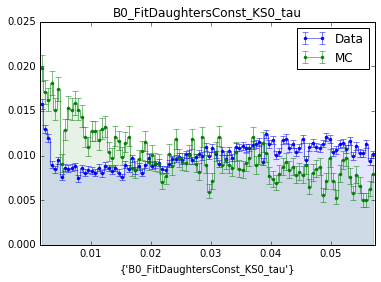

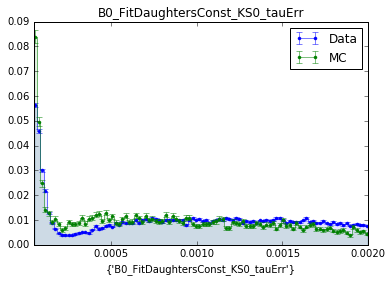

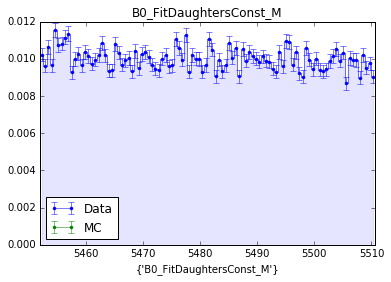

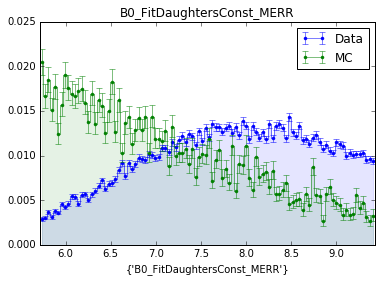

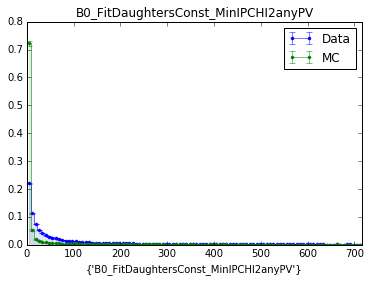

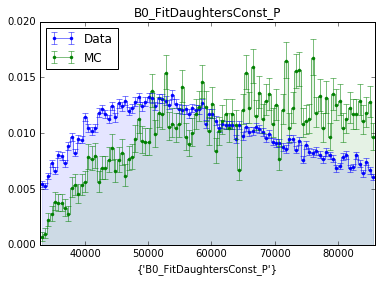

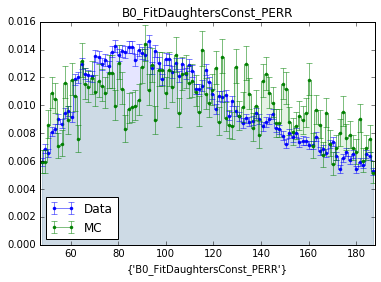

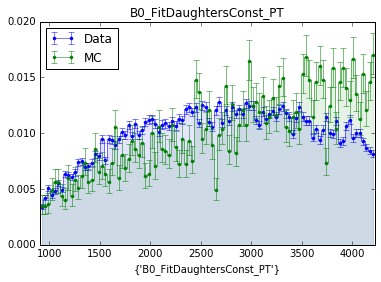

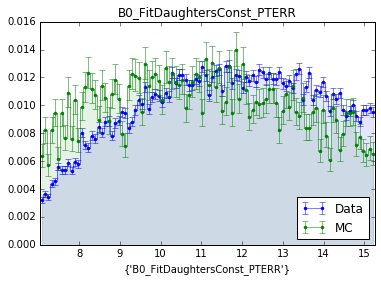

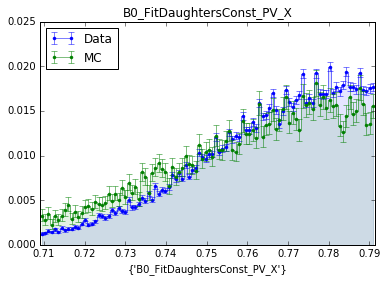

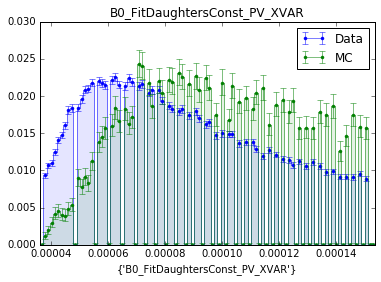

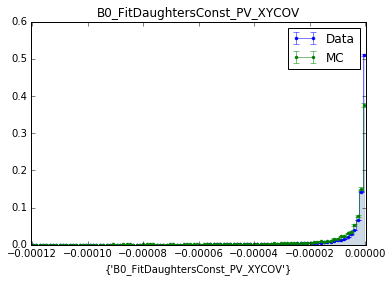

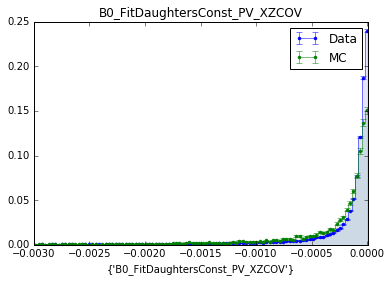

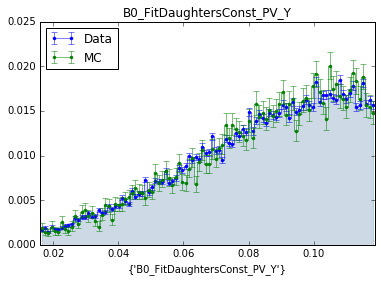

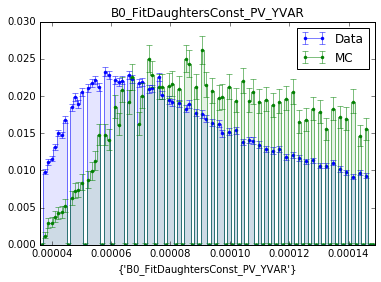

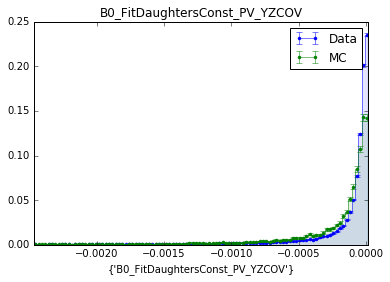

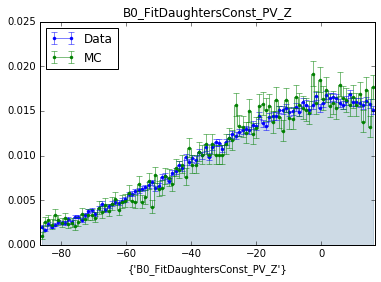

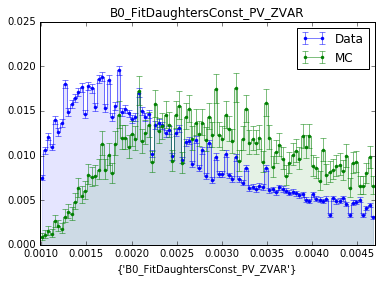

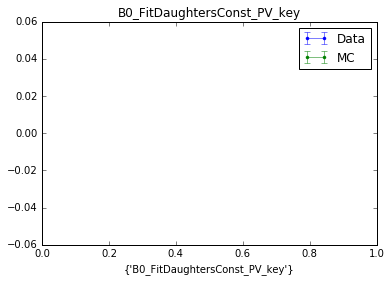

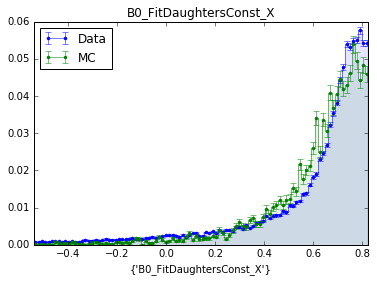

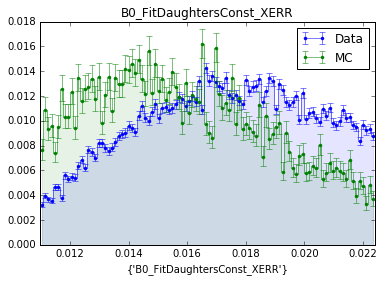

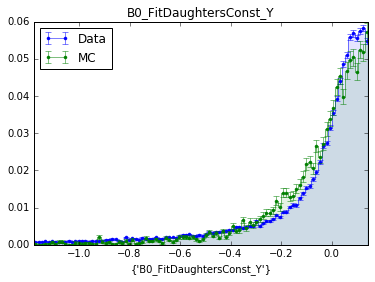

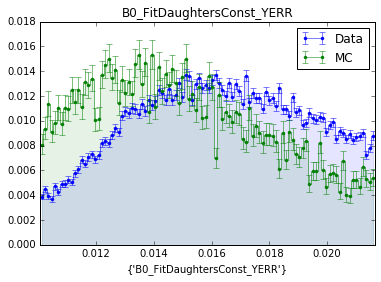

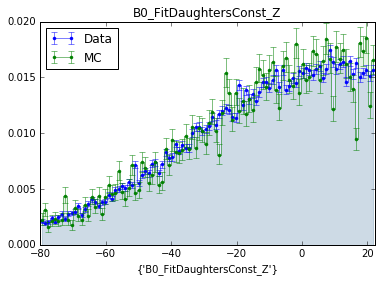

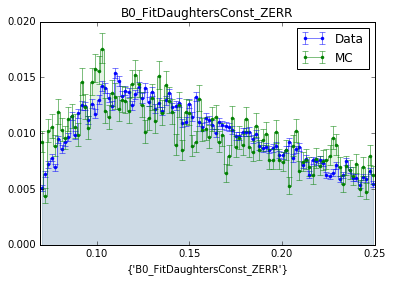

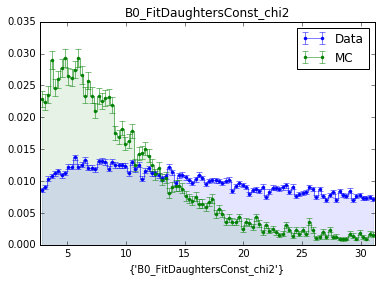

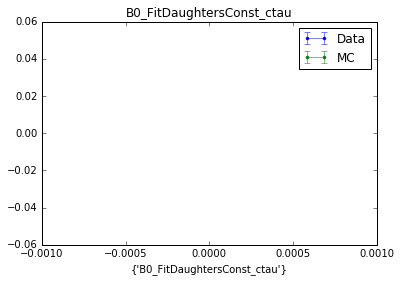

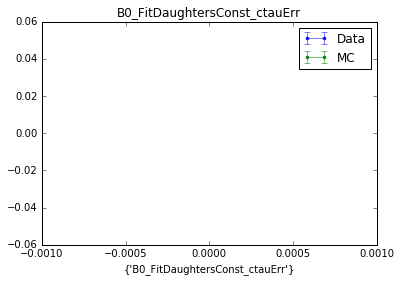

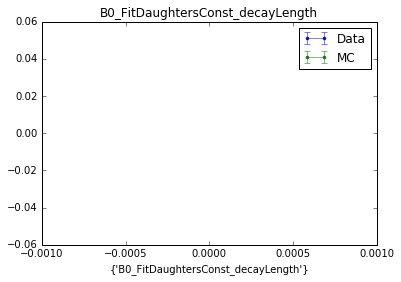

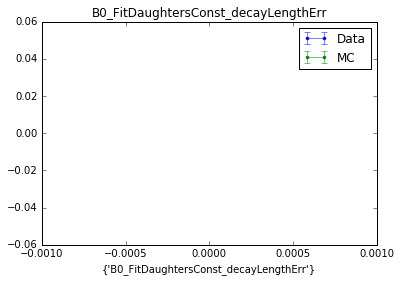

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=6.0, right=6.0
  'left=%s, right=%s') % (left, right))


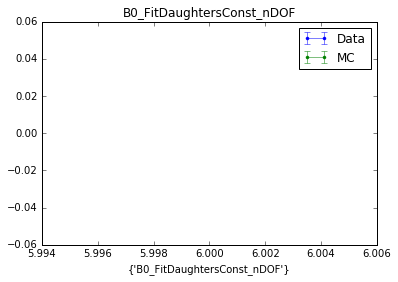

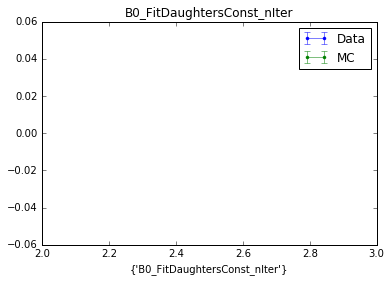

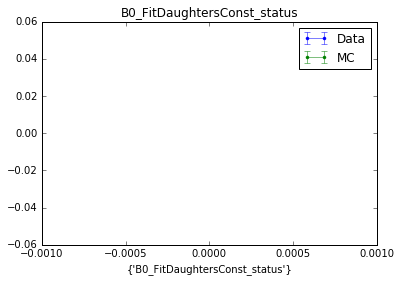

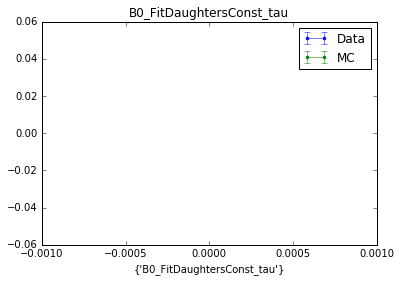

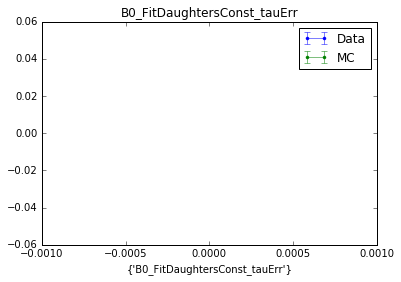

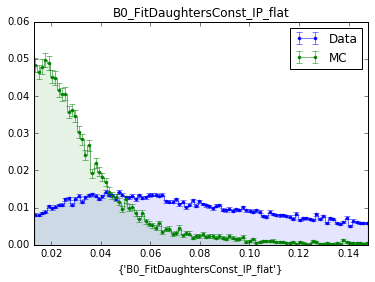

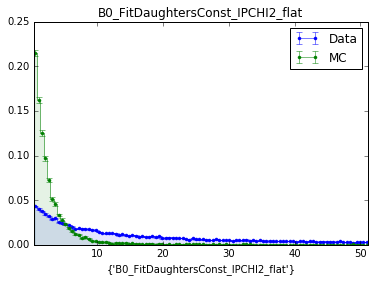

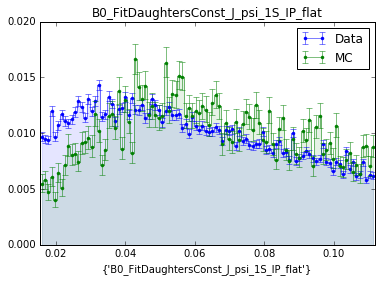

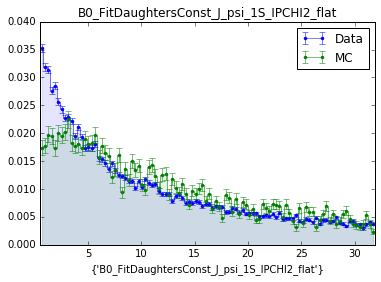

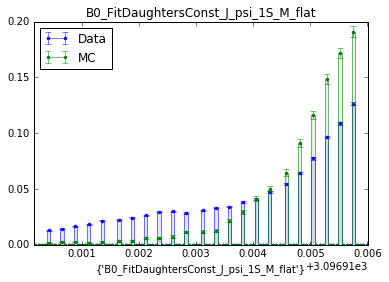

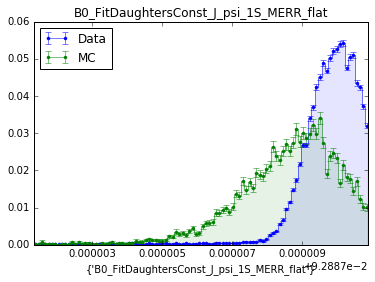

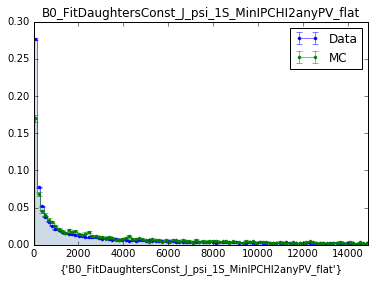

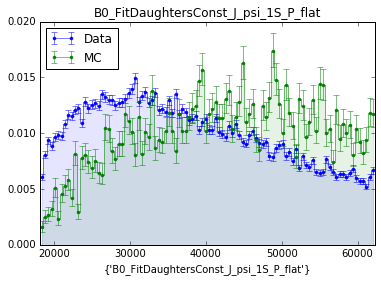

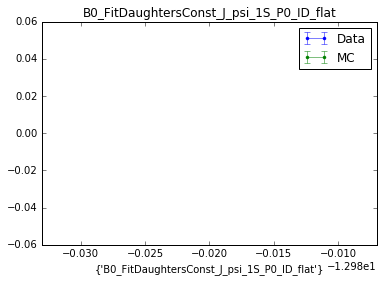

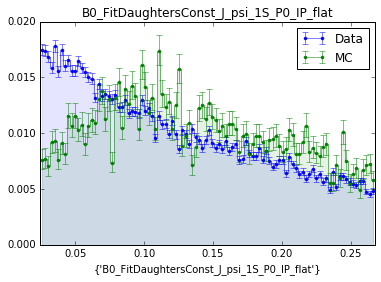

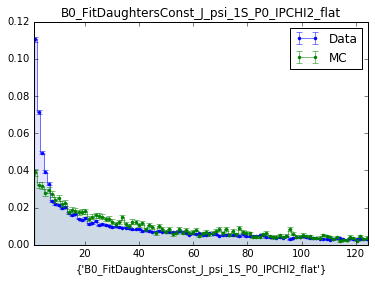

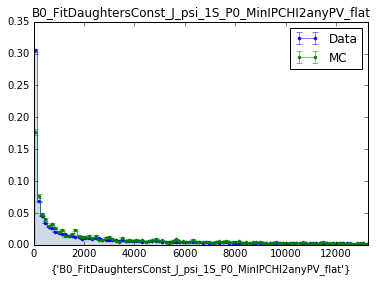

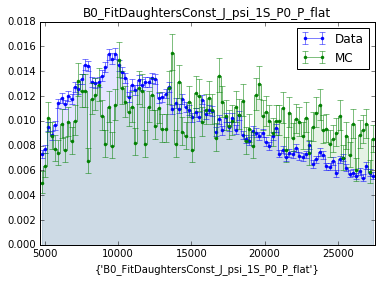

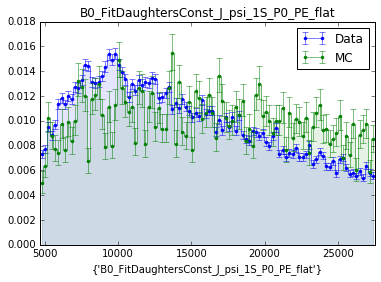

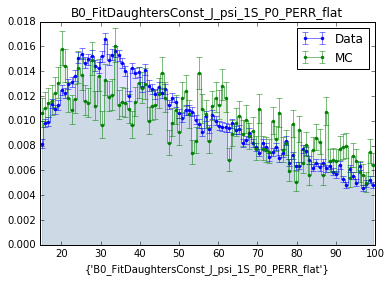

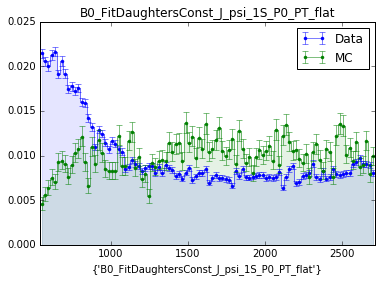

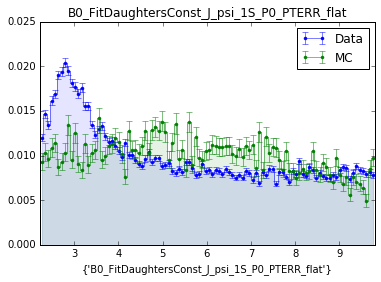

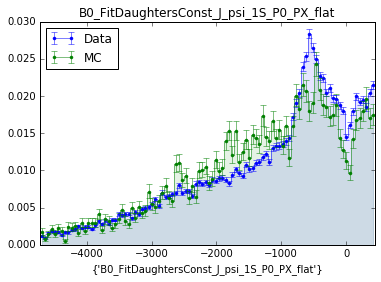

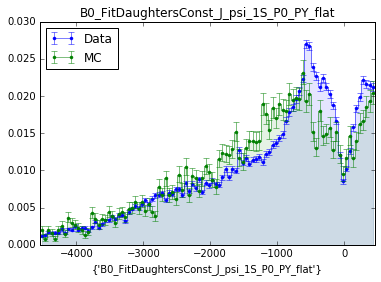

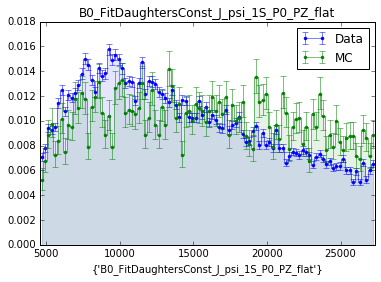

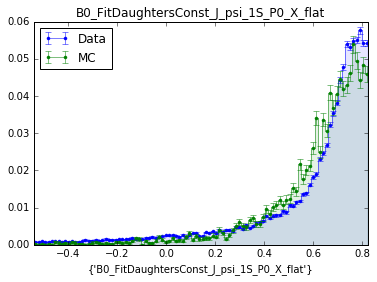

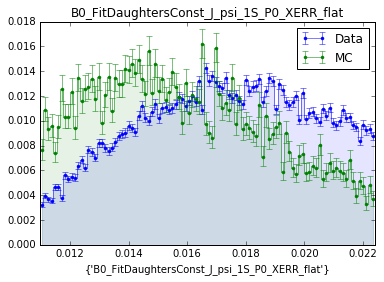

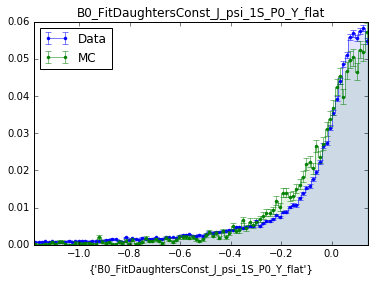

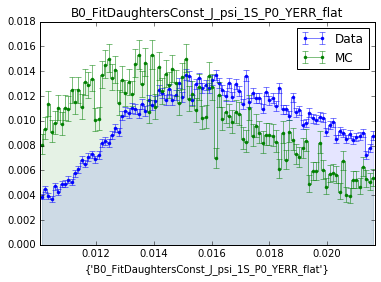

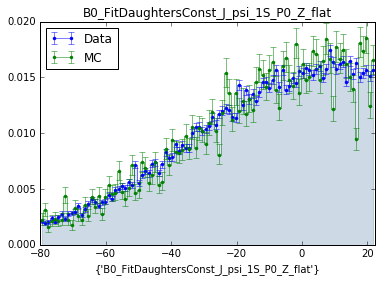

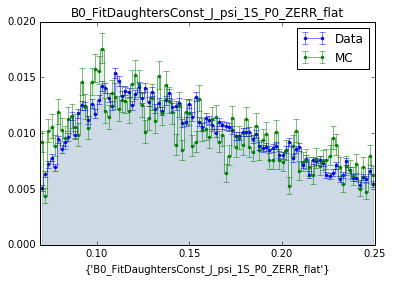

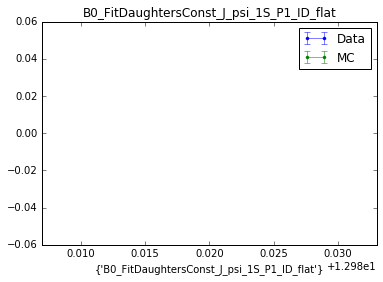

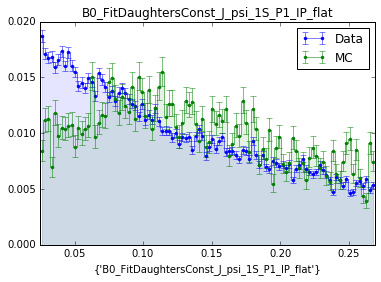

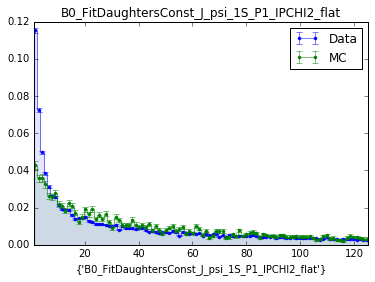

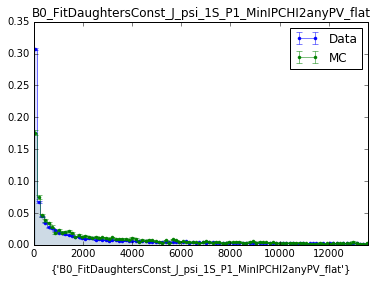

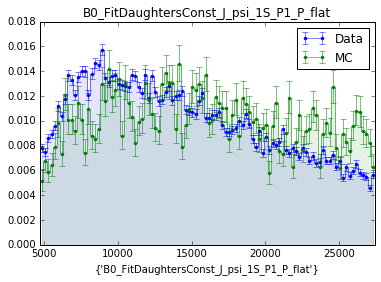

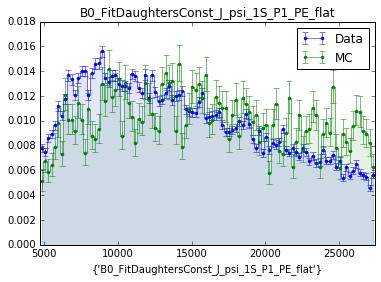

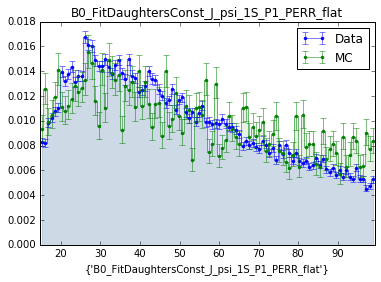

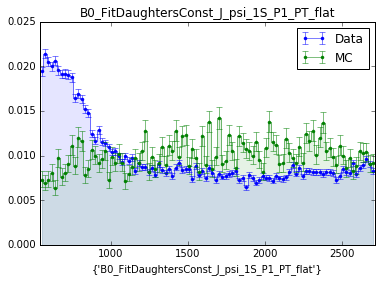

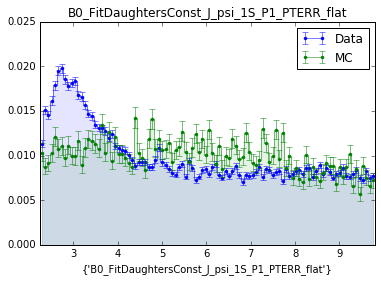

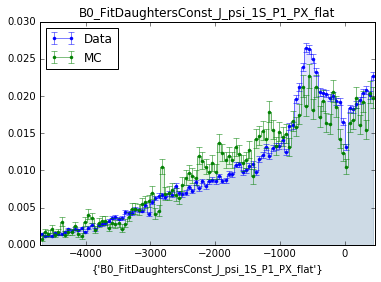

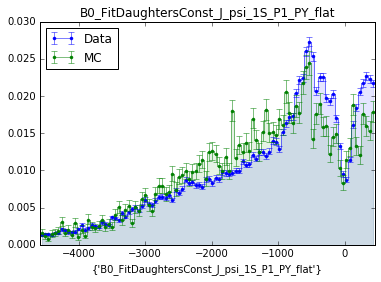

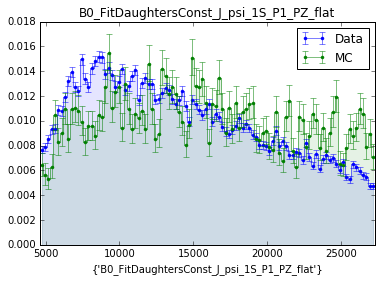

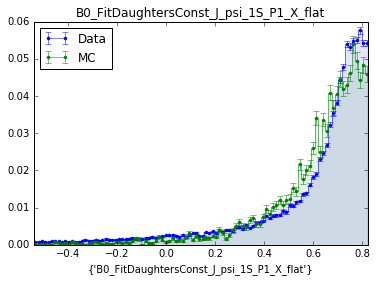

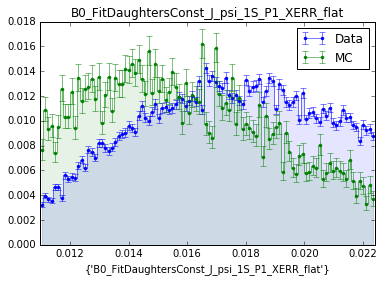

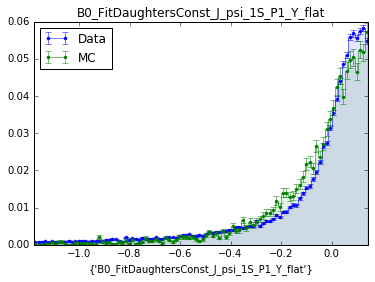

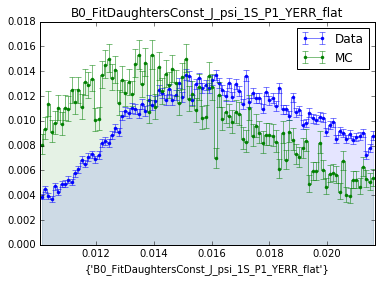

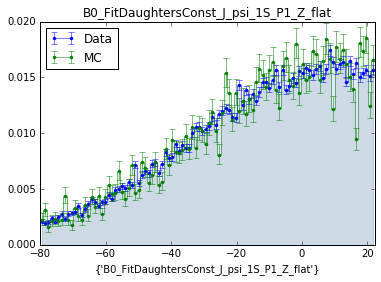

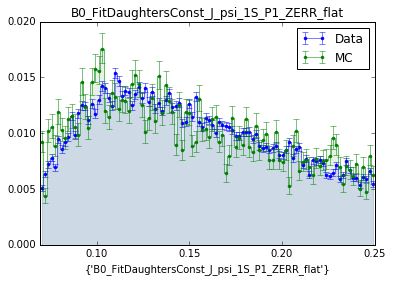

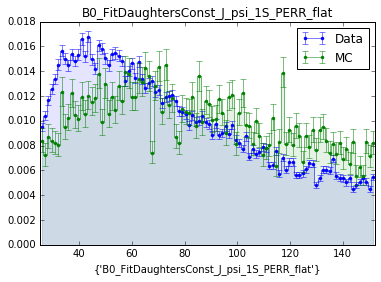

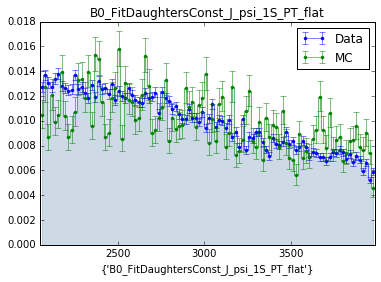

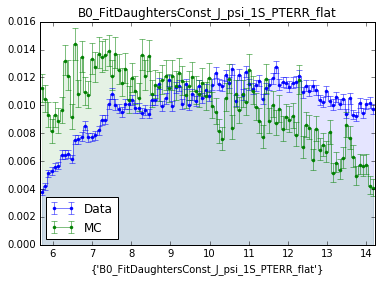

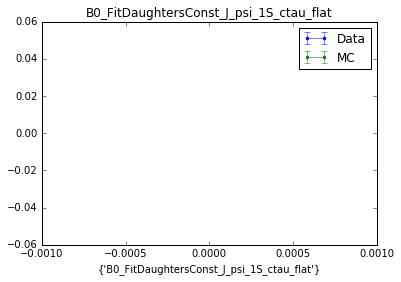

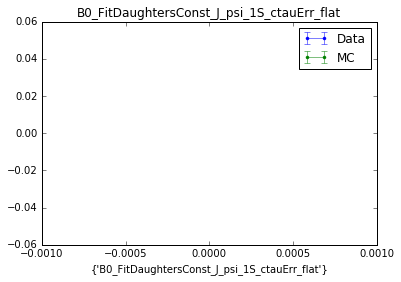

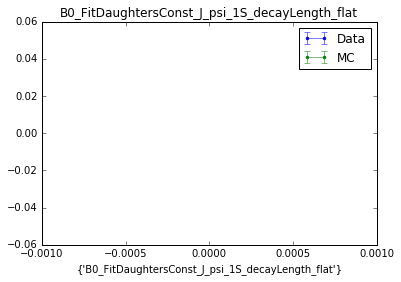

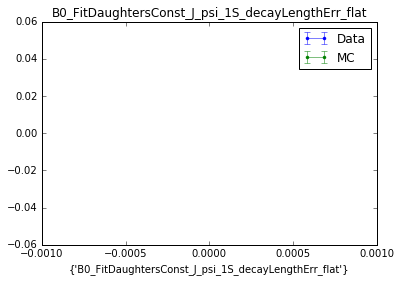

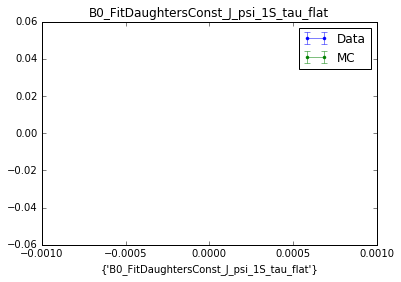

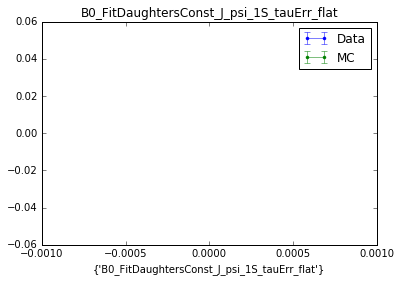

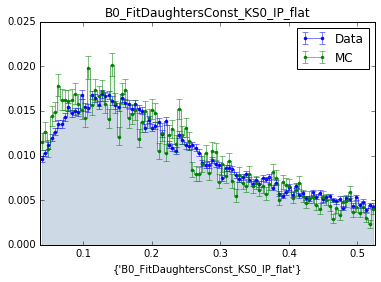

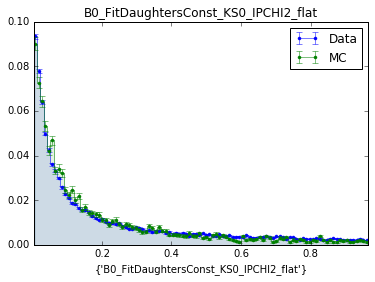

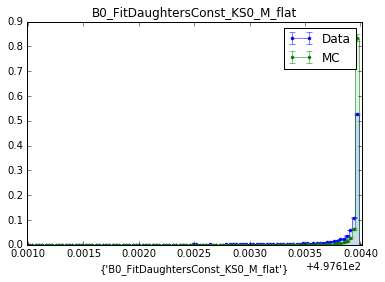

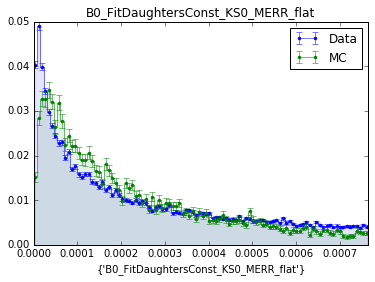

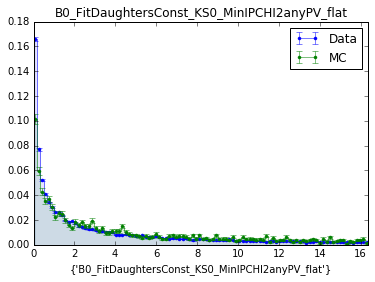

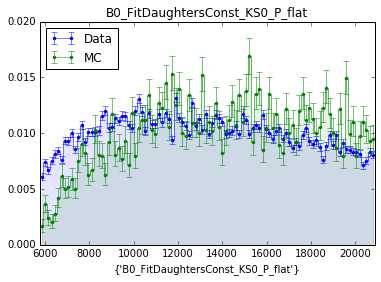

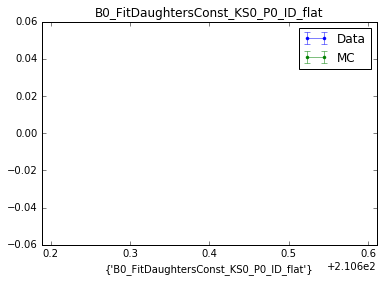

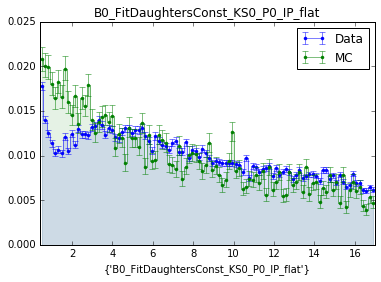

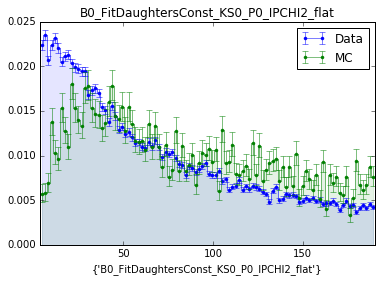

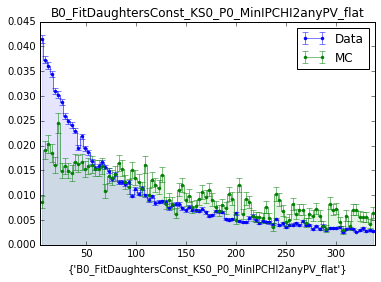

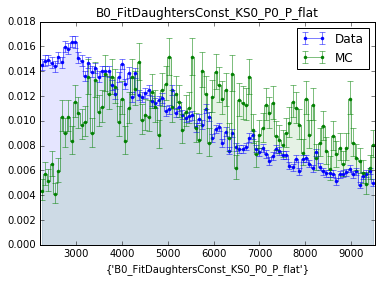

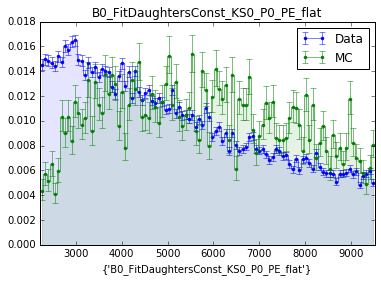

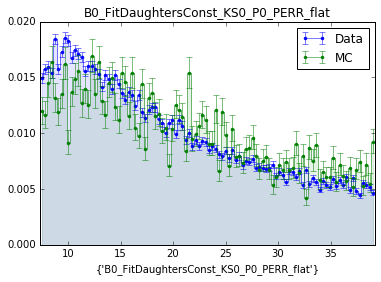

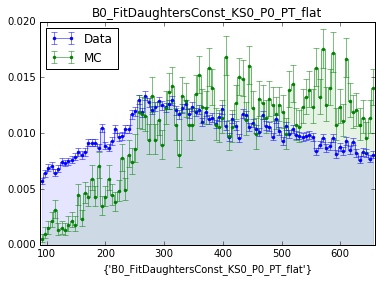

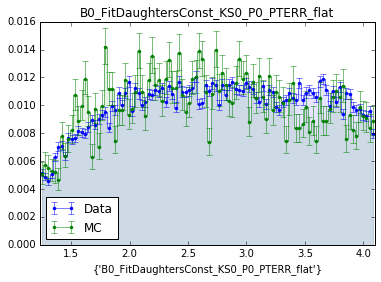

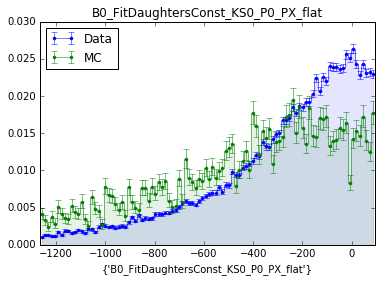

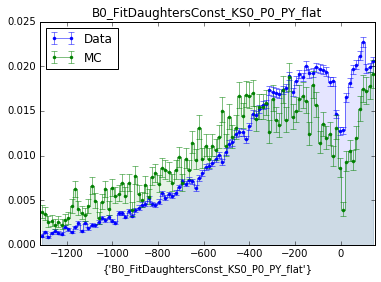

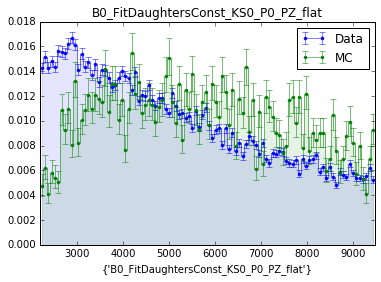

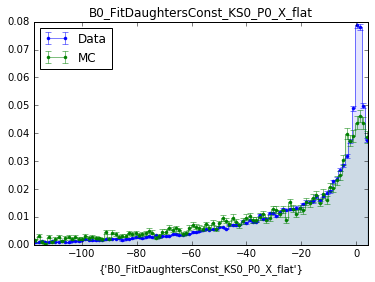

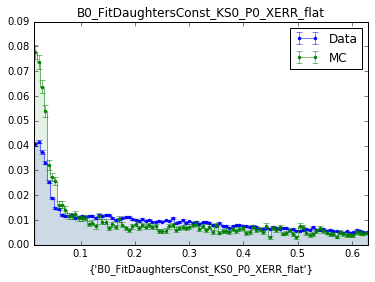

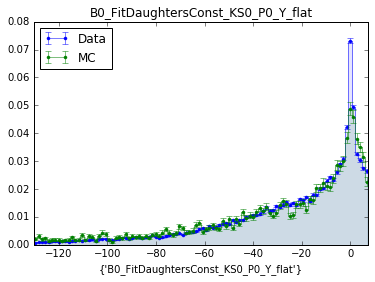

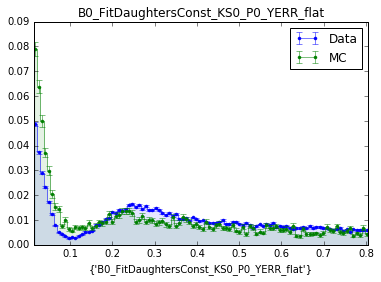

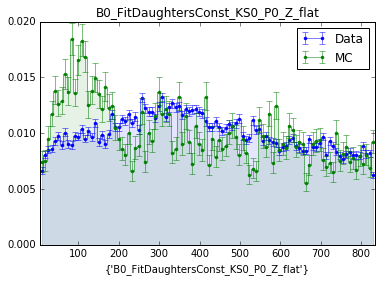

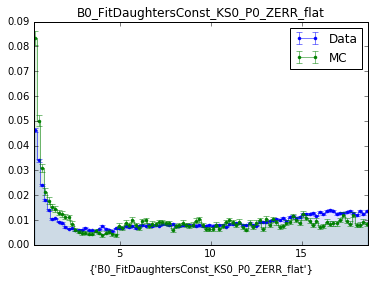

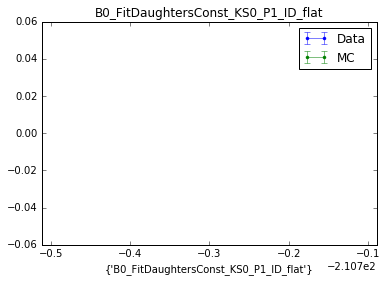

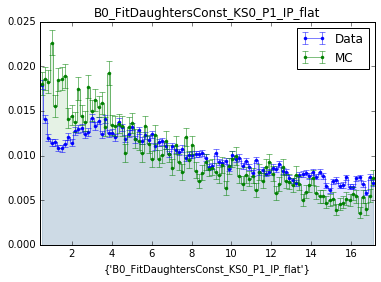

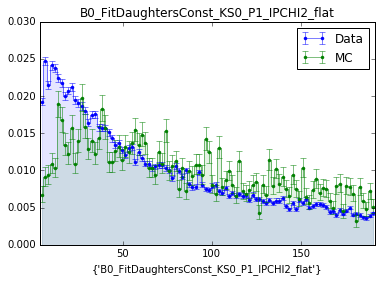

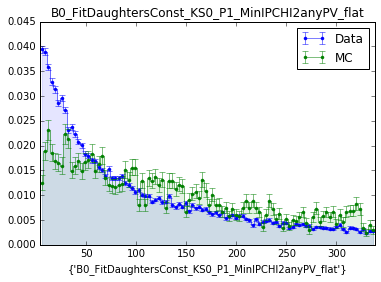

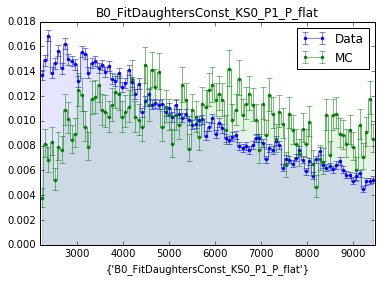

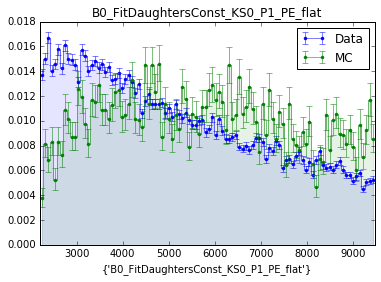

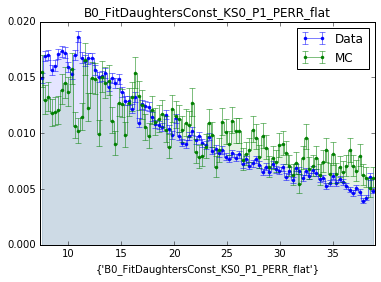

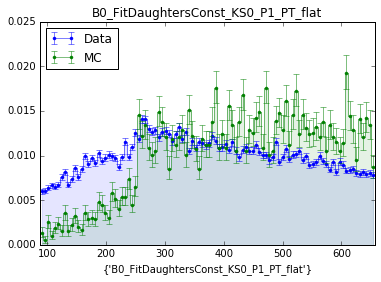

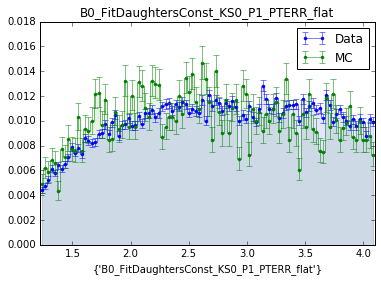

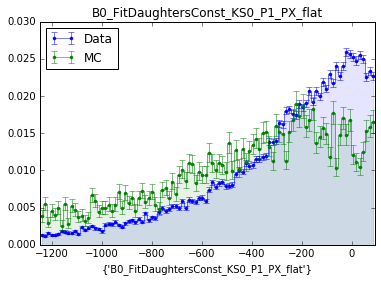

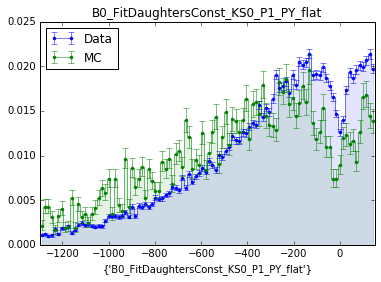

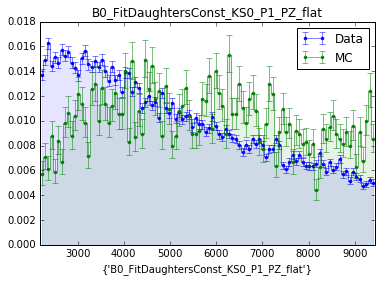

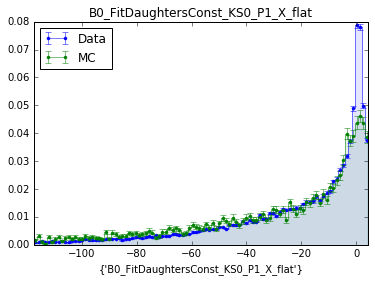

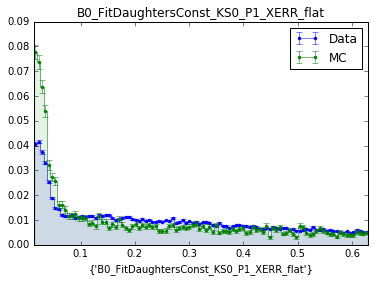

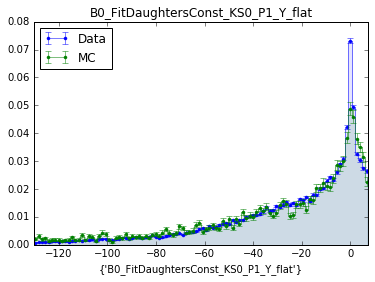

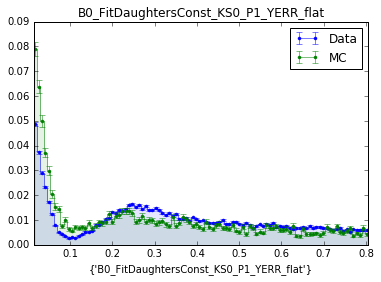

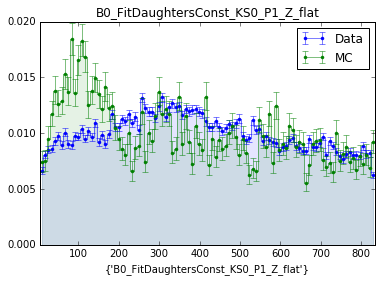

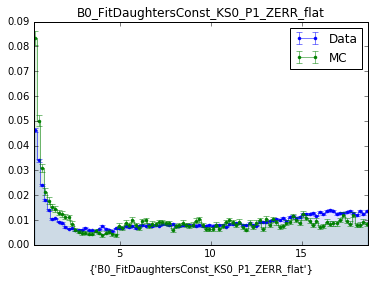

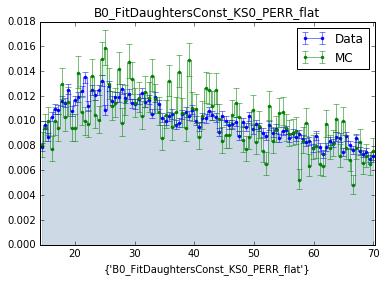

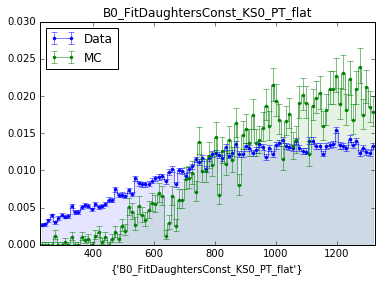

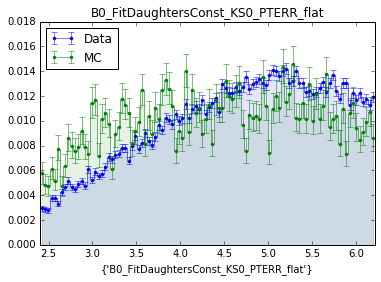

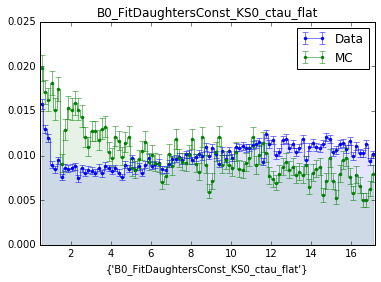

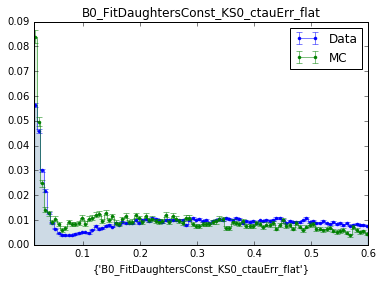

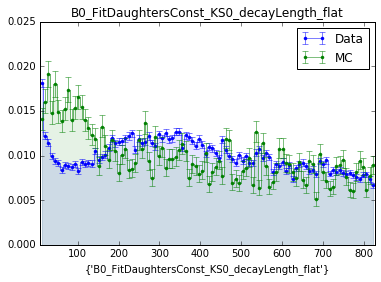

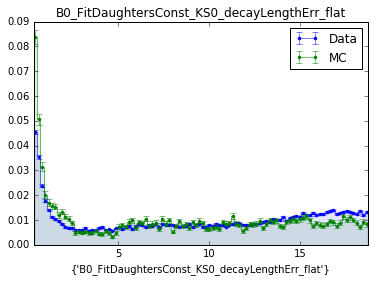

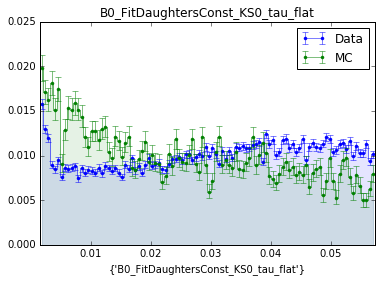

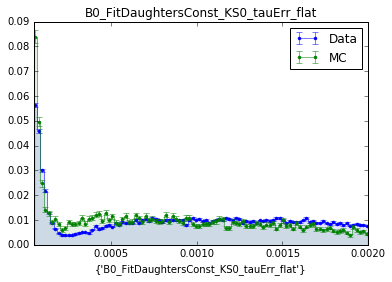

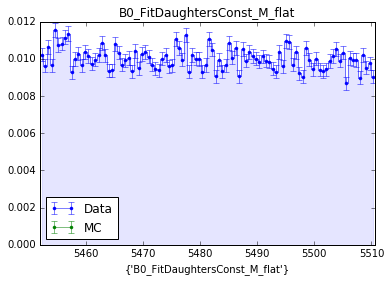

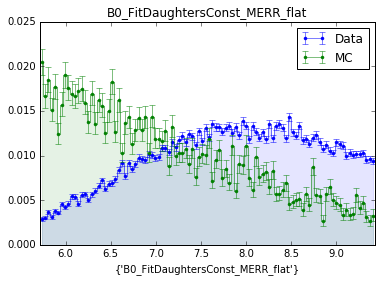

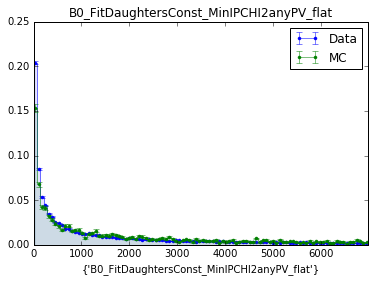

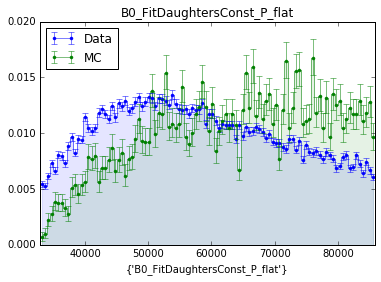

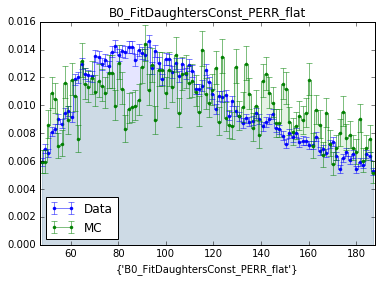

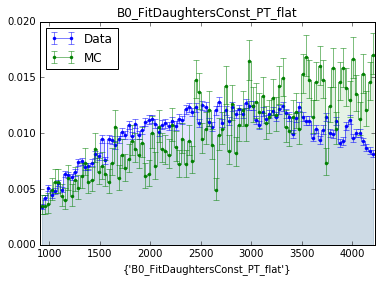

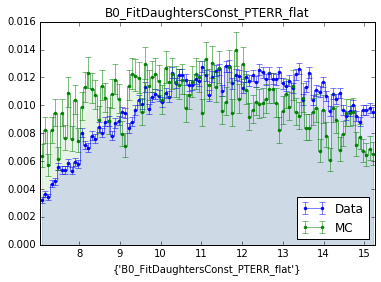

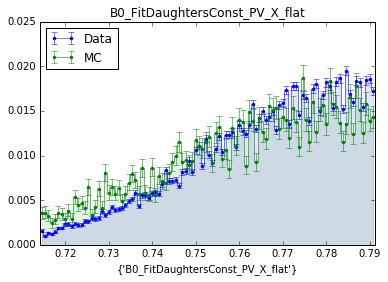

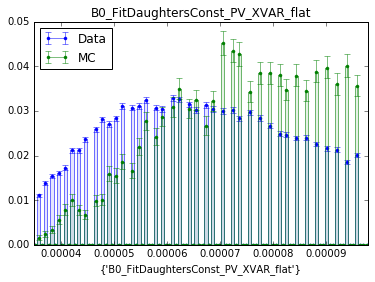

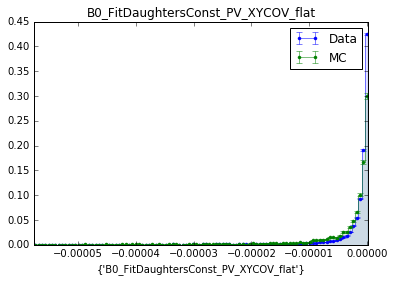

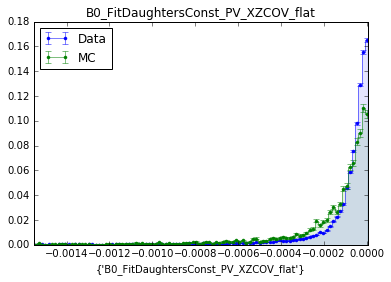

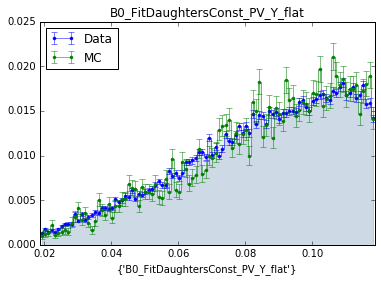

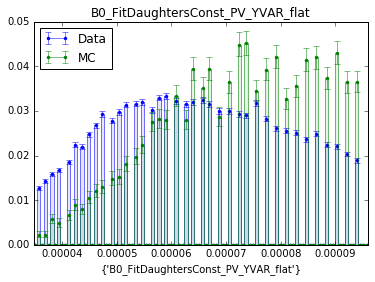

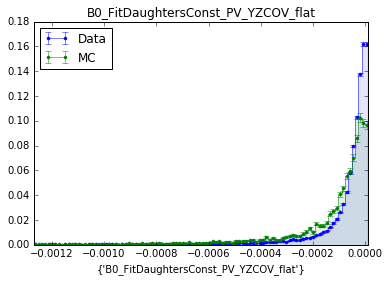

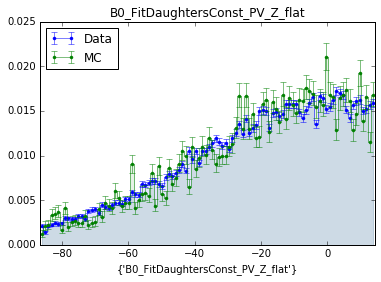

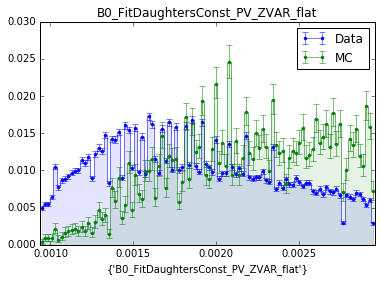

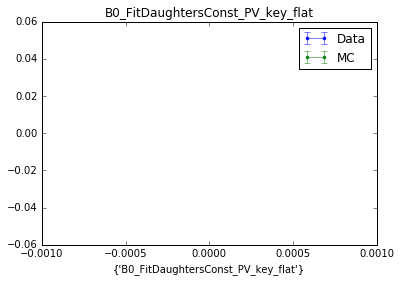

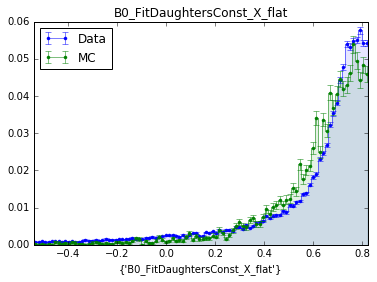

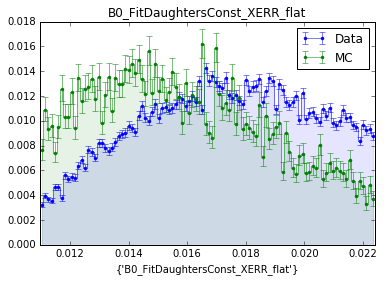

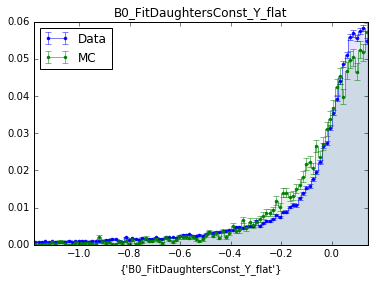

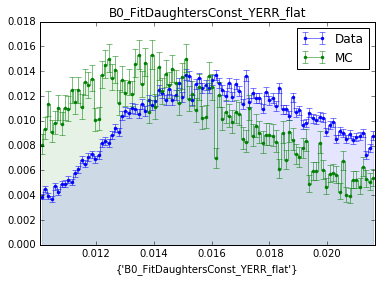

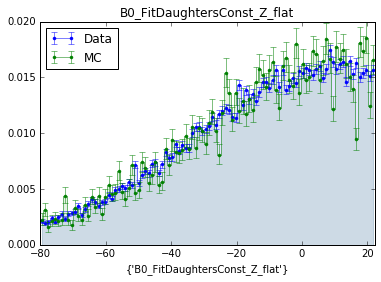

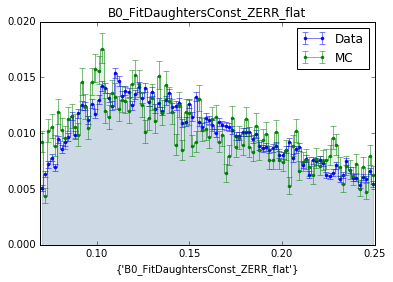

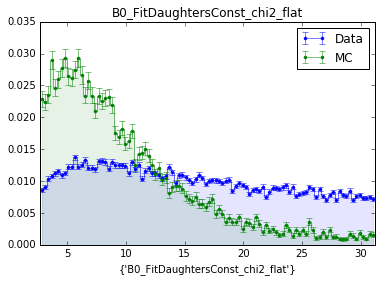

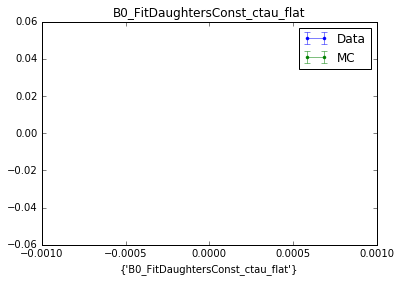

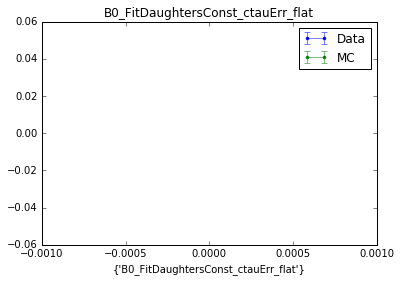

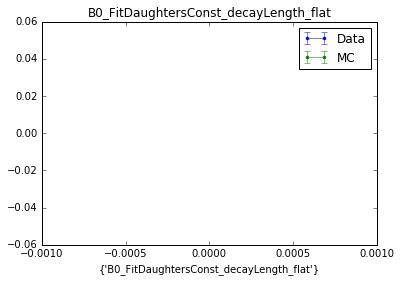

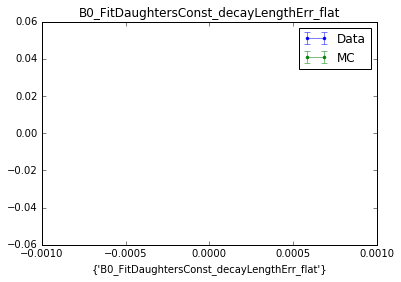

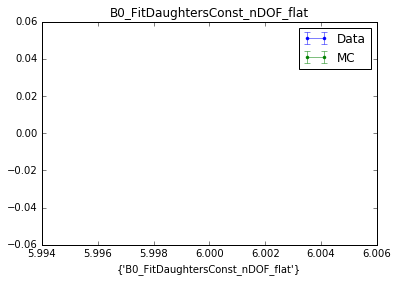

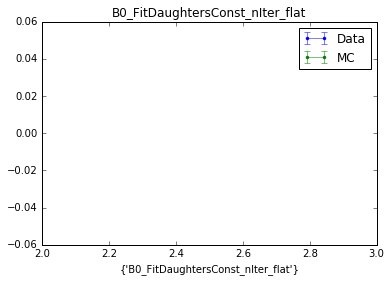

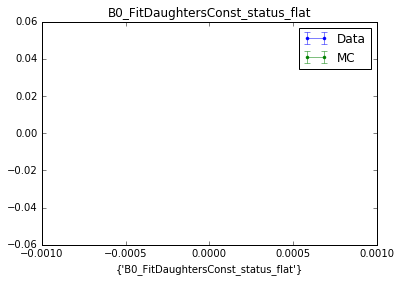

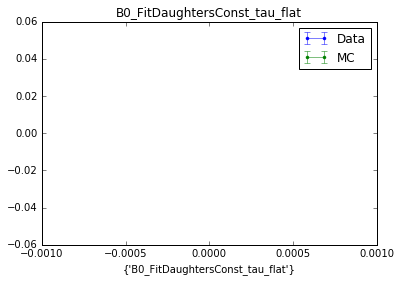

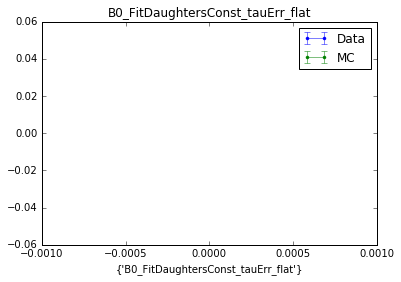

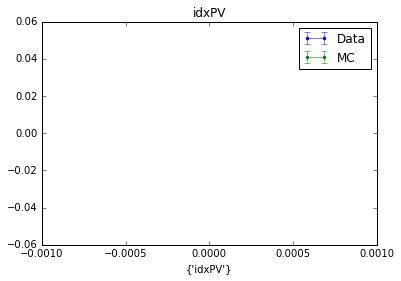

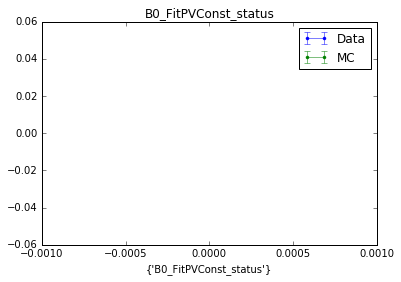

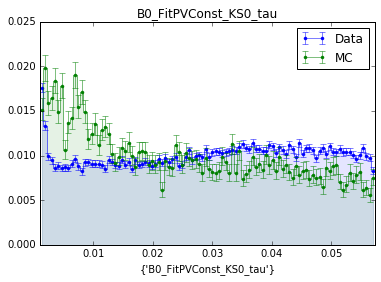

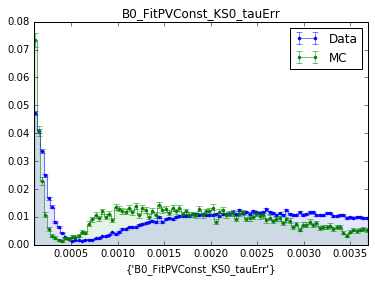

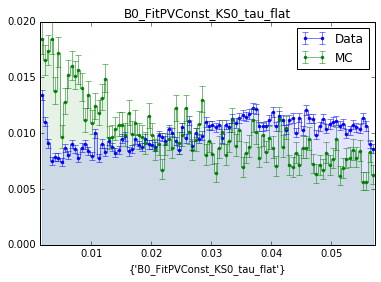

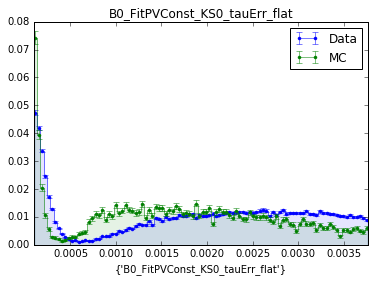

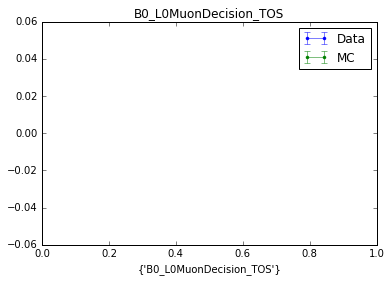

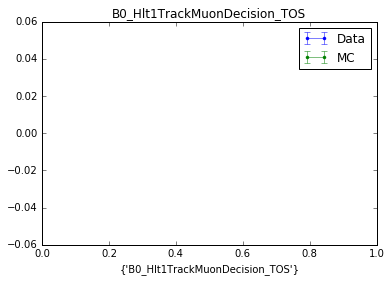

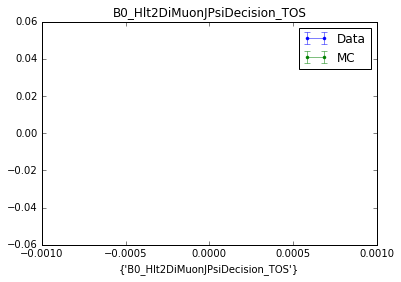

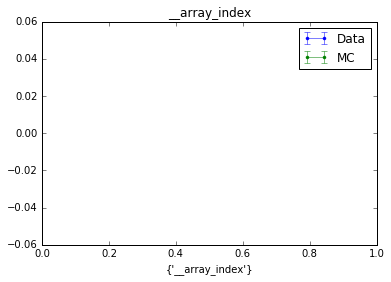

In [11]:
#Loop over all entries in the dataframes
for i in range(1,len(observables)):
    lower_limit_data = bkg_dataframe[observables[i]].quantile(0.02)
    upper_limit_data = bkg_dataframe[observables[i]].quantile(0.6)
    lower_limit_mc = signal_dataframe[observables[i]].quantile(0.02)
    upper_limit_mc = signal_dataframe[observables[i]].quantile(0.6)
    if (upper_limit_mc < upper_limit_data ) and (lower_limit_mc > lower_limit_data):
        selection_data = (bkg_dataframe[observables[i]] > lower_limit_mc) & (bkg_dataframe[observables[i]] < upper_limit_mc)
        selection_mc = (signal_dataframe[observables[i]] > lower_limit_mc) & (signal_dataframe[observables[i]] < upper_limit_mc)
        df_test = pd.DataFrame(bkg_dataframe[selection_data])
        mc_test = pd.DataFrame(signal_dataframe[selection_mc])
        p = Plotter('/home/chasenberg/plots/plots_compare/quantile_60')
        p.create_plots([df_test,mc_test],observables[i],component_labels=['Data','MC'])
        p[observables[i]].set_range(lower_limit_mc,upper_limit_mc)
        p.plot()
    else:
        selection_data = (bkg_dataframe[observables[i]] > lower_limit_data) & (bkg_dataframe[observables[i]] < upper_limit_data)
        selection_mc = (signal_dataframe[observables[i]] > lower_limit_data) & (signal_dataframe[observables[i]] < upper_limit_data) 
        df_test = pd.DataFrame(bkg_dataframe[selection_data])
        mc_test = pd.DataFrame(signal_dataframe[selection_mc])
        p = Plotter('/home/chasenberg/plots/plots_compare/quantile_60')
        p.create_plots([df_test,mc_test],observables[i],component_labels=['Data','MC'])
        p[observables[i]].set_range(lower_limit_data,upper_limit_data)
        p.plot()
#print(observables[i])
    

In [64]:
#Define branches to be used by bdt 
observables = [#'B0_FitDaughtersConst_IP',
#'B0_FitDaughtersConst_IPCHI2',
#'B0_FitDaughtersConst_KS0_P0_MinIPCHI2anyPV', 
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_PT',
'B0_FitDaughtersConst_KS0_PT',
'B0_FitDaughtersConst_KS0_P0_IPCHI2',
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitPVConst_KS0_tau_dimless',
'B0_FitDaughtersConst_J_psi_1S_P1_PT',

]

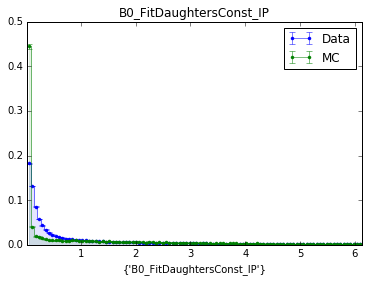

B0_FitDaughtersConst_IP


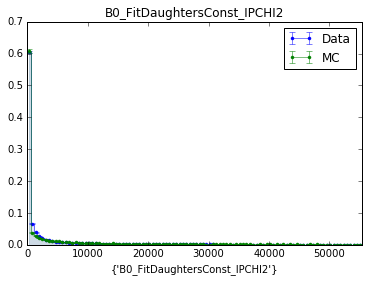

B0_FitDaughtersConst_IPCHI2


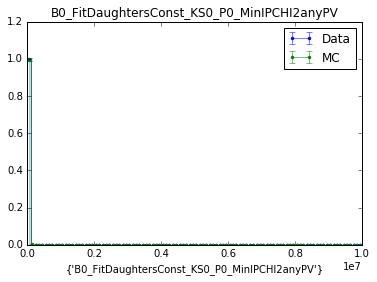

B0_FitDaughtersConst_KS0_P0_MinIPCHI2anyPV


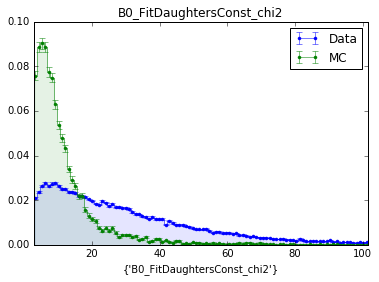

B0_FitDaughtersConst_chi2


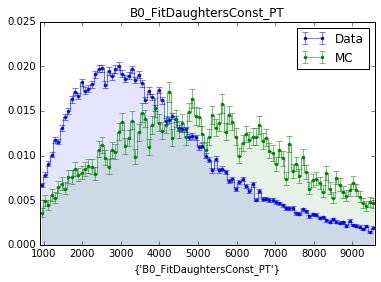

B0_FitDaughtersConst_PT


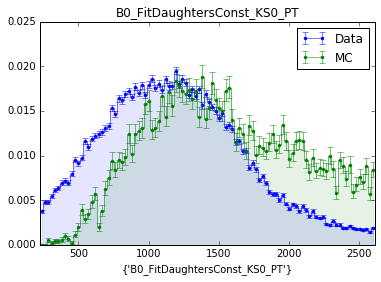

B0_FitDaughtersConst_KS0_PT


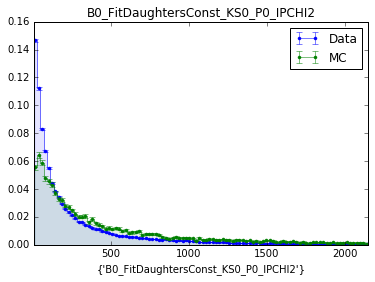

B0_FitDaughtersConst_KS0_P0_IPCHI2


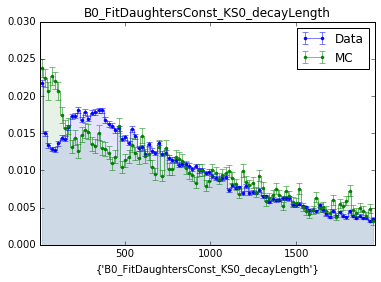

B0_FitDaughtersConst_KS0_decayLength


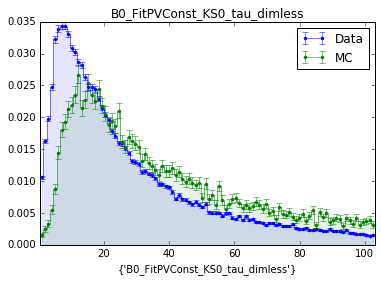

B0_FitPVConst_KS0_tau_dimless


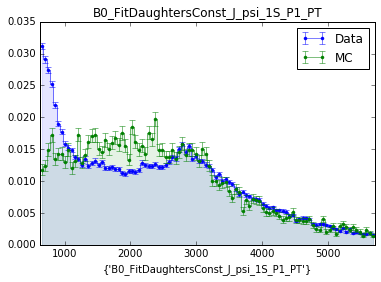

B0_FitDaughtersConst_J_psi_1S_P1_PT


In [63]:
#Loop over all entries in the dataframes
for i in range(0,len(observables)):
    lower_limit_data = bkg_dataframe[observables[i]].quantile(0.02)
    upper_limit_data = bkg_dataframe[observables[i]].quantile(0.95)
    lower_limit_mc = signal_dataframe[observables[i]].quantile(0.02)
    upper_limit_mc = signal_dataframe[observables[i]].quantile(0.95)
    if (upper_limit_mc < upper_limit_data ) and (lower_limit_mc > lower_limit_data):
        selection_data = (bkg_dataframe[observables[i]] > lower_limit_mc) & (bkg_dataframe[observables[i]] < upper_limit_mc)
        selection_mc = (signal_dataframe[observables[i]] > lower_limit_mc) & (signal_dataframe[observables[i]] < upper_limit_mc)
        df_test = pd.DataFrame(bkg_dataframe[selection_data])
        mc_test = pd.DataFrame(signal_dataframe[selection_mc])
        p = Plotter('/home/chasenberg/plots/plots_compare/bdt_variables')
        p.create_plots([df_test,mc_test],observables[i],component_labels=['Data','MC'])
        p[observables[i]].set_range(lower_limit_mc,upper_limit_mc)
        p.plot()
        print(observables[i])
    else:
        selection_data = (bkg_dataframe[observables[i]] > lower_limit_data) & (bkg_dataframe[observables[i]] < upper_limit_data)
        selection_mc = (signal_dataframe[observables[i]] > lower_limit_data) & (signal_dataframe[observables[i]] < upper_limit_data) 
        df_test = pd.DataFrame(bkg_dataframe[selection_data])
        mc_test = pd.DataFrame(signal_dataframe[selection_mc])
        p = Plotter('/home/chasenberg/plots/plots_compare/bdt_variables')
        p.create_plots([df_test,mc_test],observables[i],component_labels=['Data','MC'])
        p[observables[i]].set_range(lower_limit_data,upper_limit_data)
        p.plot()
        print(observables[i])
    

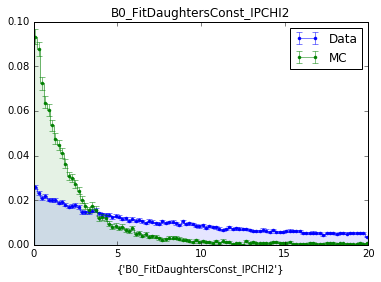

In [65]:
#Plot only chi2
p = Plotter('/home/chasenberg/plots/plots_compare/bdt_variables/')
p.create_plots([df_test,mc_test],'B0_FitDaughtersConst_IPCHI2',component_labels=['Data','MC'])
p['B0_FitDaughtersConst_IPCHI2'].set_range(0,20)
p.plot()

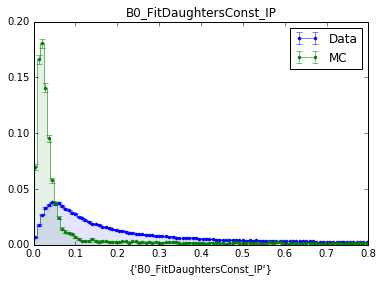

In [66]:
#Plot only COnst_IP
p = Plotter('/home/chasenberg/plots/plots_compare/bdt_variables/')
p.create_plots([df_test,mc_test],'B0_FitDaughtersConst_IP',component_labels=['Data','MC'])
p['B0_FitDaughtersConst_IP'].set_range(0,0.8)
p.plot()

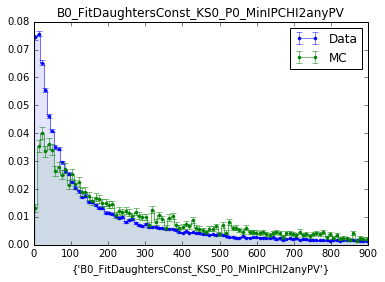

In [72]:
#Plot only MinIPCHI2anyPV
p = Plotter('/home/chasenberg/plots/plots_compare/bdt_variables/')
p.create_plots([df_test,mc_test],'B0_FitDaughtersConst_KS0_P0_MinIPCHI2anyPV',component_labels=['Data','MC'])
p['B0_FitDaughtersConst_KS0_P0_MinIPCHI2anyPV'].set_range(0,900)
p.plot()